<a href="https://colab.research.google.com/github/following-the-rabbit/pet_projects/blob/main/security/security.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Информационная безопасность.


## Описание проекта:
Компания онлайн-сервис с высоким уровнем входящего трафика имеет
специализированный отдел безопасности, который занимается фильтрацией и анализом
трафика. Сотрудники этого отдела обратились за помощью в автоматизации выявления
аномального и злонамеренного трафика. Необходимо разработать модель, которая
будет классифицировать трафик на нормальный и злонамеренный.

## Цель проекта:
* Разработать модель, которая будет классифицировать трафик на нормальный и
злонамеренный, с выделением класс каждого. При этом модель должна работать максимально качественно, так как
цена ошибки может быть очень высока.
* Оценить качество модели по различным метрикам классификации: precision, recall,
f1_score, accuracy.
* (*) Деплой: разработать REST API сервис, который будет принимать на вход данные
трафика и возвращать класс этого трафика

# Импорт библиотек и инструментов.

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
import lightgbm
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка данных.

In [3]:
df = pd.read_csv('/content/drive/MyDrive/network_traffic_data.csv')

In [4]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,5480074,3,1,12,0,6,0,4.000,3.465,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,443,711977,9,10,703,3950,267,0,78.100,103.300,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,53,153398,2,2,80,224,40,40,40.000,0.000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,53,57660,1,1,46,128,46,46,46.000,0.000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,8446,767,3,1,43,6,31,6,14.336,14.440,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


**Описание данных**  

Признаки имеют отношение к различным аспектам характеристик сетевых пакетов. В их числе можно выделить:
1.	"Destination Port" - порт назначения для конкретного пакета.
2.	"Flow Duration" - продолжительность общей активности потока трафика.
3.	"Total Fwd Packets" и "Total Backward Packets" - общее количество пакетов, отправленных вперед (к получателю) и назад (к источнику) соответственно.
4.	"Total Length of Fwd Packets"/"Total Length of Bwd Packets" - общая длина пакетов, отправленных вперед и назад.
5.	"Fwd Packet Length Max"/"Min"/"Mean"/"Std" - максимальная, минимальная, средняя длина и стандартное отклонение длины пакетов, отправленных вперед.
6.	"Flow Bytes/s" и "Flow Packets/s" - скорость потока в байтах и пакетах в секунду.
7.	"Flow IAT Mean"/"Std"/"Max"/"Min" - среднее значение, стандартное отклонение, максимальное и минимальное время между прибытием двух последовательных пакетов (Inter-Arrival Time).
8.	"Fwd IAT Total"/"Mean"/"Std"/"Max"/"Min" и "Bwd IAT Total"/"Mean"/"Std"/"Max"/"Min" - общее время, среднее, стандартное отклонение, максимальное и минимальное время между отправкой двух последовательных пакетов вперед и назад.
9.	"Fwd PSH Flags", "Bwd PSH Flags", "Fwd URG Flags", "Bwd URG Flags" - количество меток PSH и URG в пакетах, направленных вперед и назад. Эти метки используются для управления протоколом TCP.
10.	"Fwd Header Length", "Bwd Header Length" - длина заголовка пакета, переданного вперед или назад.
11.	"Fwd Packets/s", "Bwd Packets/s" - скорость отправки пакетов вперед и назад соответственно.
12.	"Min Packet Length", "Max Packet Length", "Packet Length Mean", "Packet Length Std", "Packet Length Variance" - минимальная, максимальная, средняя длина пакета, стандартное отклонение и дисперсия длины пакета.
13.	"FIN Flag Count", "SYN Flag Count", "RST Flag Count", "PSH Flag Count", "ACK Flag Count", "URG Flag Count", "CWE Flag Count", "ECE Flag Count" - количество различных типов флагов TCP в потоке.
14. "Label" - маркер нормального и злонамеренного трафика.


In [5]:
df.Label.unique()

array(['BENIGN', 'PortScan', 'DoS Hulk', 'DDoS', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS GoldenEye', 'Heartbleed'],
      dtype=object)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             539616 non-null  int64  
 1    Flow Duration                539616 non-null  int64  
 2    Total Fwd Packets            539616 non-null  int64  
 3    Total Backward Packets       539616 non-null  int64  
 4   Total Length of Fwd Packets   539616 non-null  int64  
 5    Total Length of Bwd Packets  539616 non-null  int64  
 6    Fwd Packet Length Max        539616 non-null  int64  
 7    Fwd Packet Length Min        539616 non-null  int64  
 8    Fwd Packet Length Mean       539616 non-null  float64
 9    Fwd Packet Length Std        539616 non-null  float64
 10  Bwd Packet Length Max         539616 non-null  int64  
 11   Bwd Packet Length Min        539616 non-null  int64  
 12   Bwd Packet Length Mean       539616 non-nul

# Предобработка данных


Обработка дубликатов.

In [7]:
sum(df.duplicated())

64601

Создадим отдельный датафрейм без дубликатов.

In [8]:
df2 = df.drop_duplicates().reset_index(drop=True)

In [9]:
sum(df2.duplicated())

0

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475015 entries, 0 to 475014
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             475015 non-null  int64  
 1    Flow Duration                475015 non-null  int64  
 2    Total Fwd Packets            475015 non-null  int64  
 3    Total Backward Packets       475015 non-null  int64  
 4   Total Length of Fwd Packets   475015 non-null  int64  
 5    Total Length of Bwd Packets  475015 non-null  int64  
 6    Fwd Packet Length Max        475015 non-null  int64  
 7    Fwd Packet Length Min        475015 non-null  int64  
 8    Fwd Packet Length Mean       475015 non-null  float64
 9    Fwd Packet Length Std        475015 non-null  float64
 10  Bwd Packet Length Max         475015 non-null  int64  
 11   Bwd Packet Length Min        475015 non-null  int64  
 12   Bwd Packet Length Mean       475015 non-nul

В признаке 'Flow Bytes/s' обнаружены пропуски и значения бесконечности, обработаем их.

In [11]:
df2['Flow Bytes/s'].isna().sum()

40

In [12]:
df2.replace([np.inf, -np.inf], np.nan, inplace=True)

In [13]:
df2['Flow Bytes/s'].isna().sum()

262

Поставим заглушку в виде "-1" вместо пропусков.

In [14]:
df2 = df2.fillna(-1).reset_index(drop=True)

In [15]:
df2['Flow Bytes/s'].isna().sum()

0

In [16]:
df2.isnull().any().any()

False

Пропуски отсутствуют.

# Визуализация данных.

In [17]:
def show_hists(data, data_label, num_bins, rug=False, log_scale=False):
    """
    input: data - данные для построения гистограммы
           data_label - описание данных
           num_bins - количество ячеек
    output: None
    description: Функция строит гистограмму и boxplot для выбранного параметра:
                - Плотность распределения (методом distplot() библиотеки seaborn)
                - Boxplot (метод boxplot() библиотеки seaborn)
    """
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label, fontsize=18)
    sns.histplot(data, bins=num_bins, ax=axes[0])
    sns.violinplot(data=data, ax=axes[1])
    plt.show()

In [18]:
columns_features = df2.columns.to_list()[:-1]

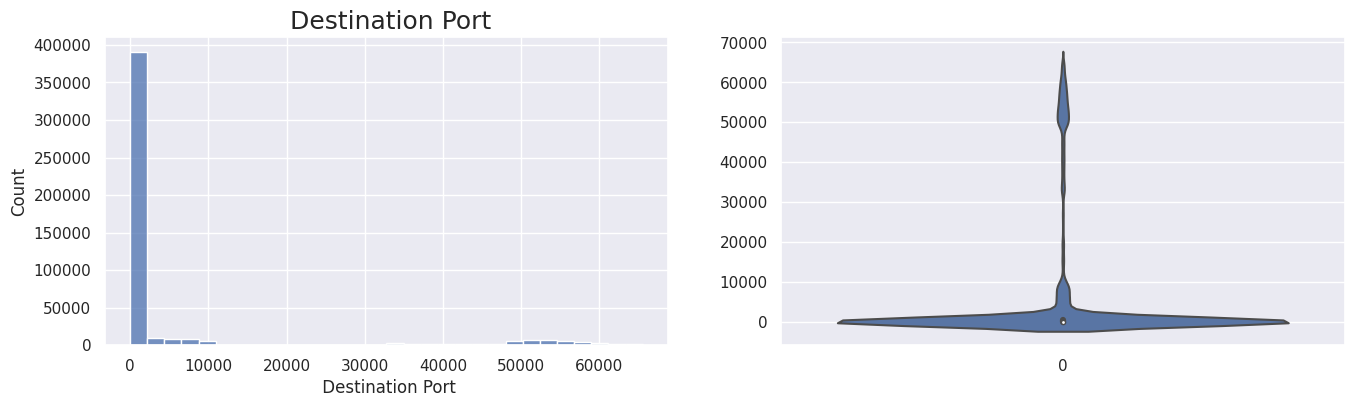

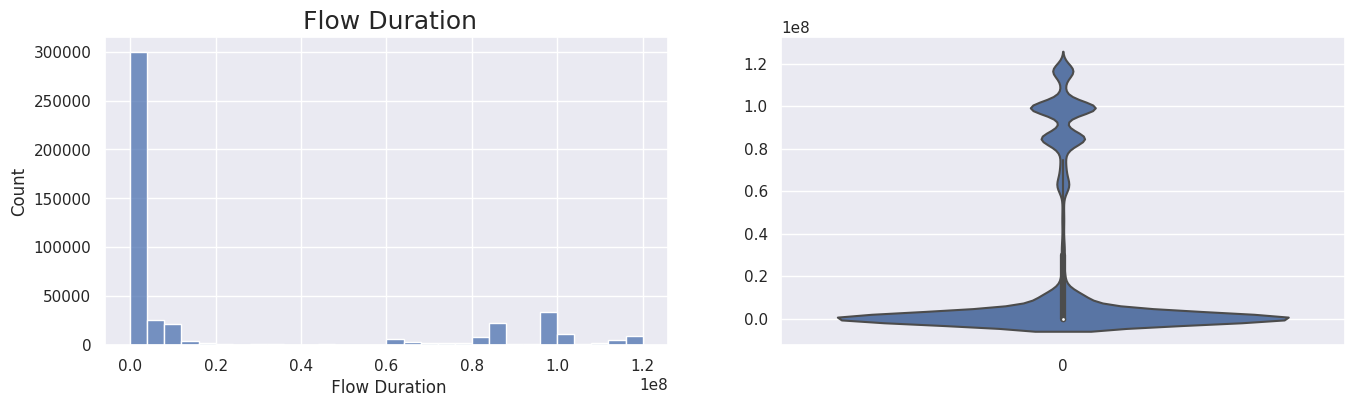

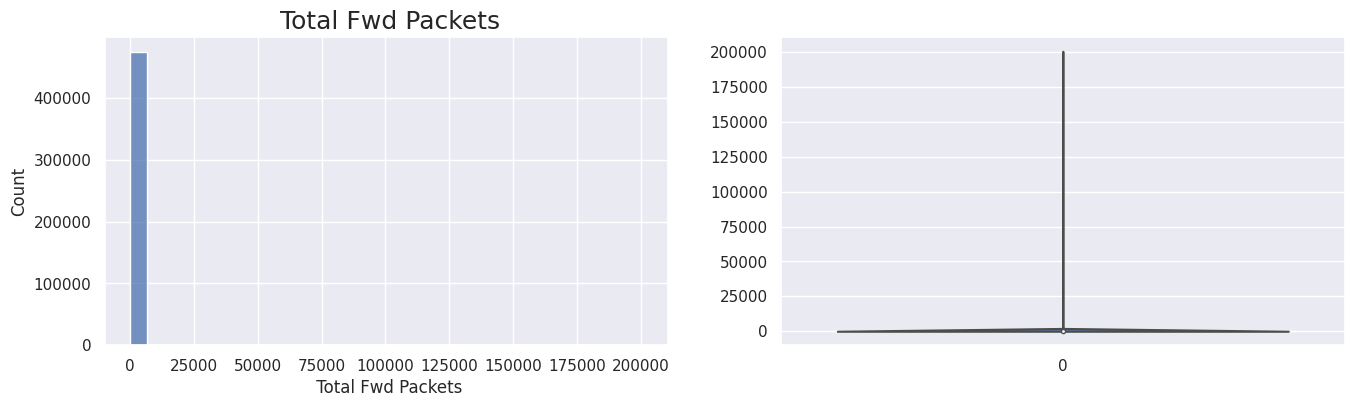

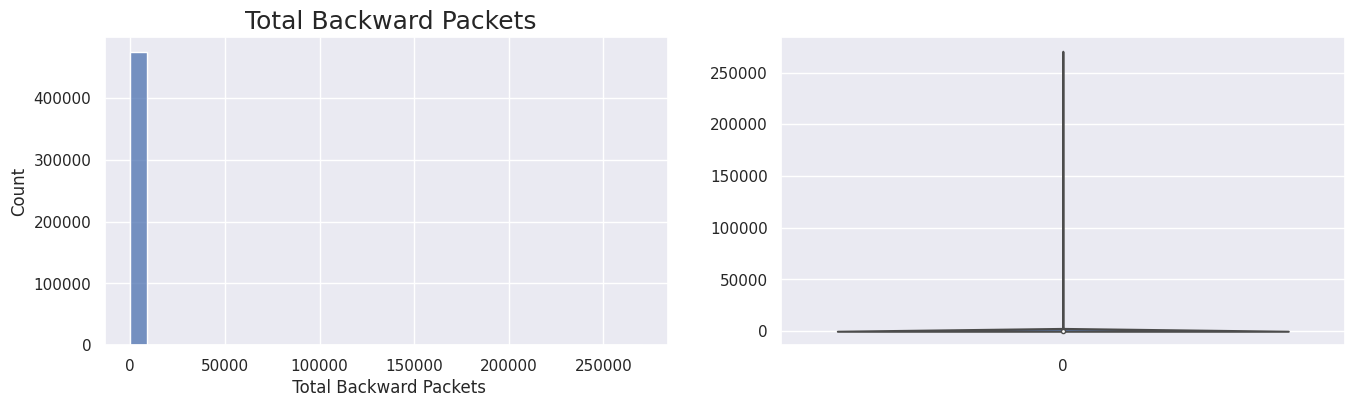

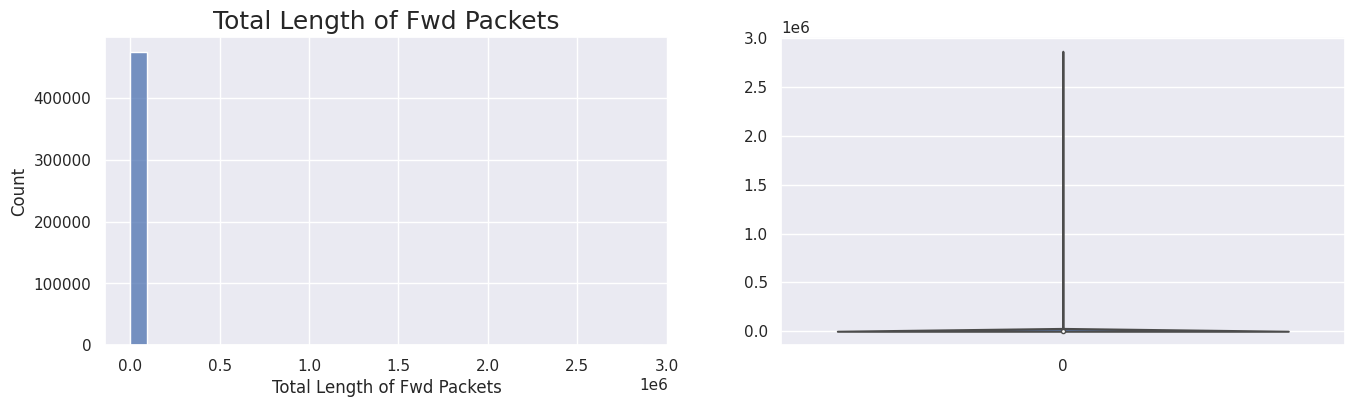

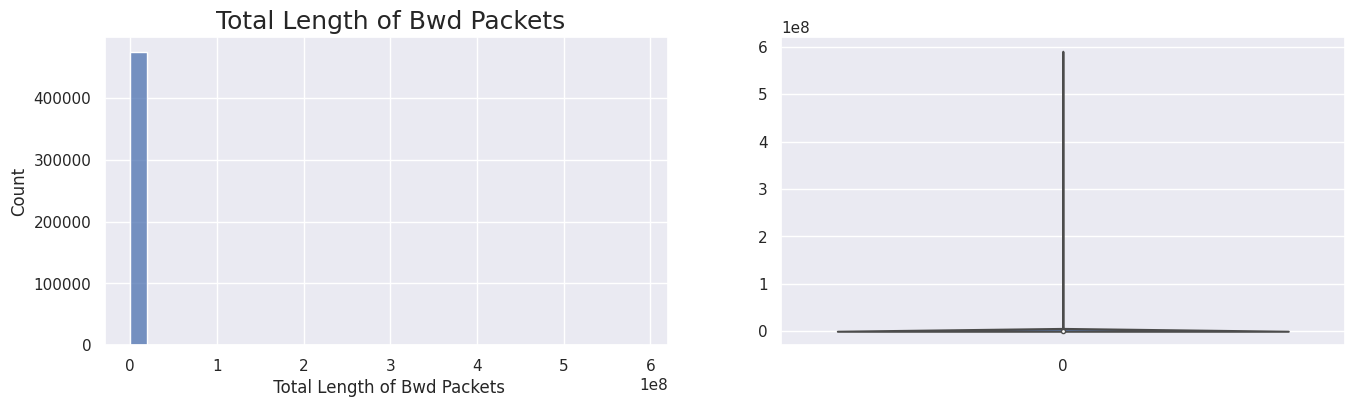

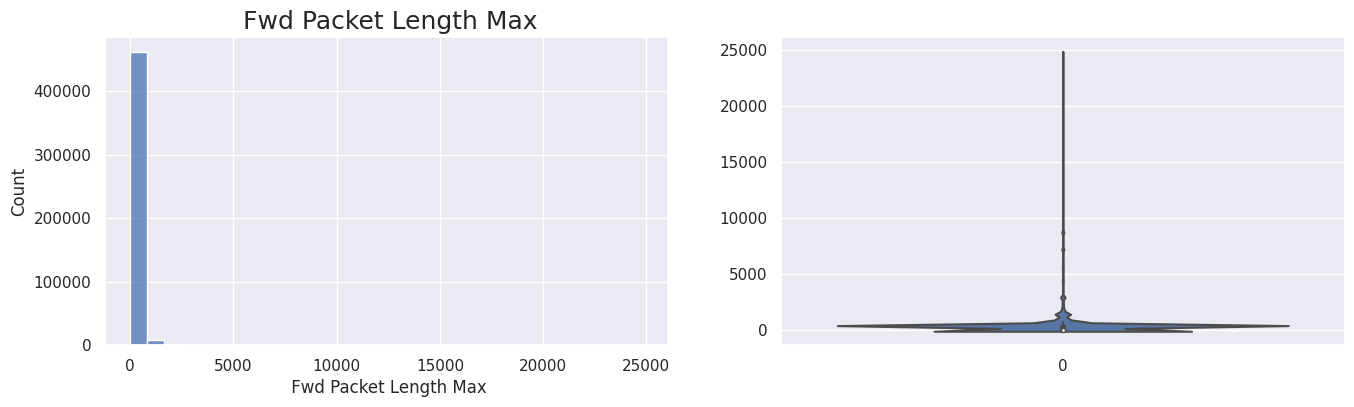

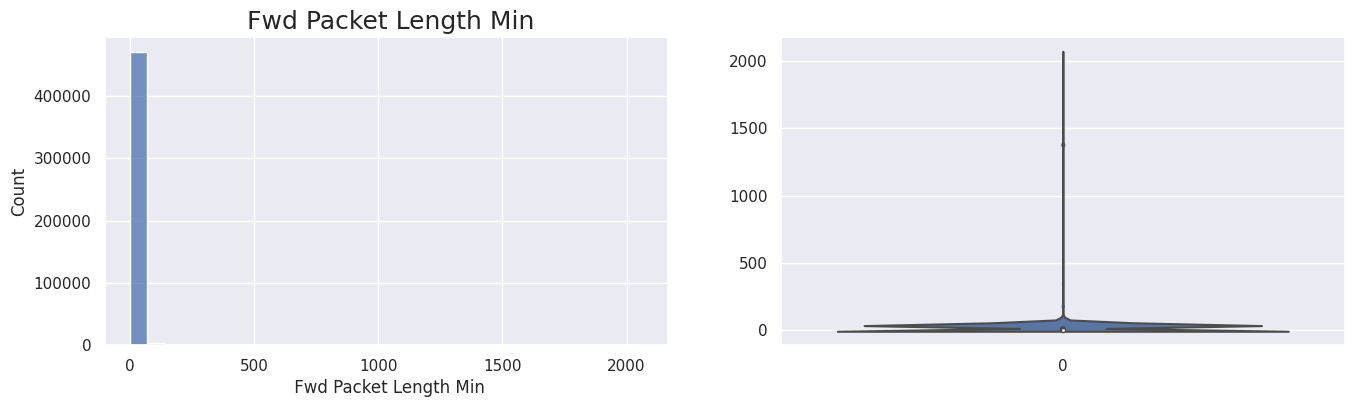

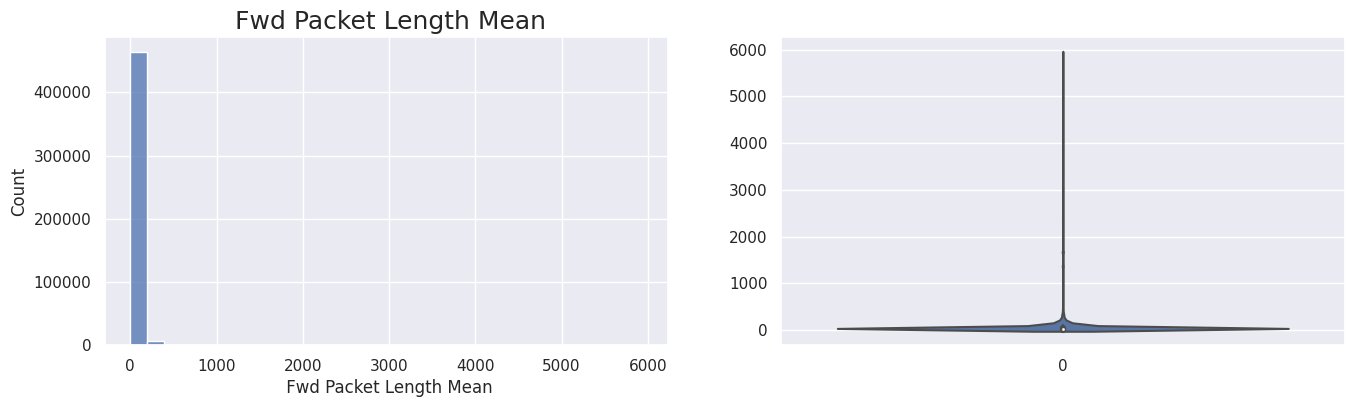

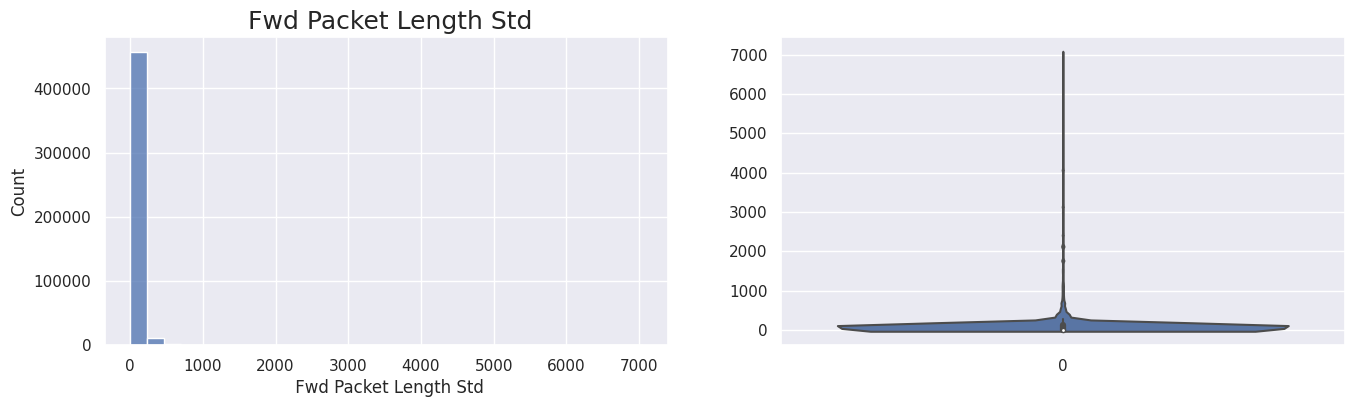

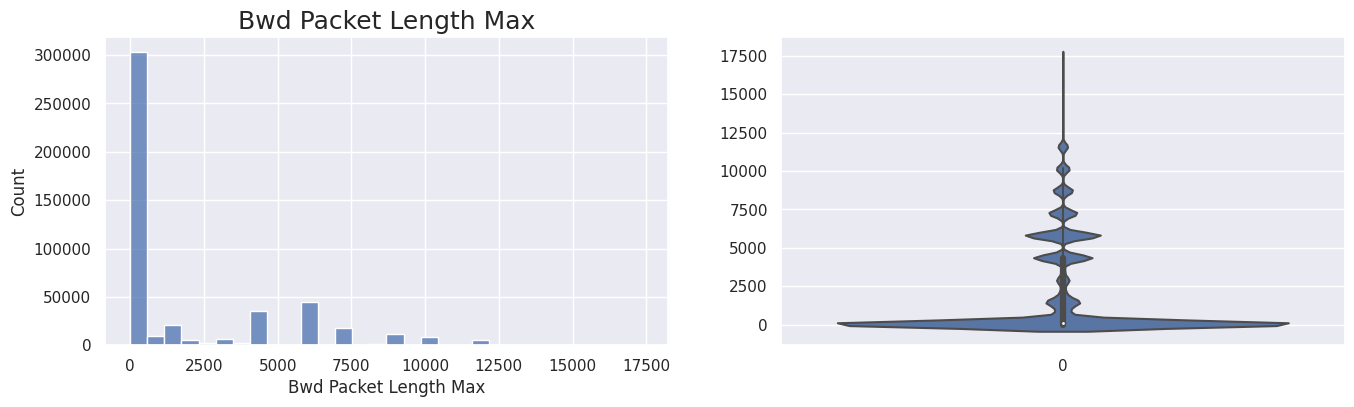

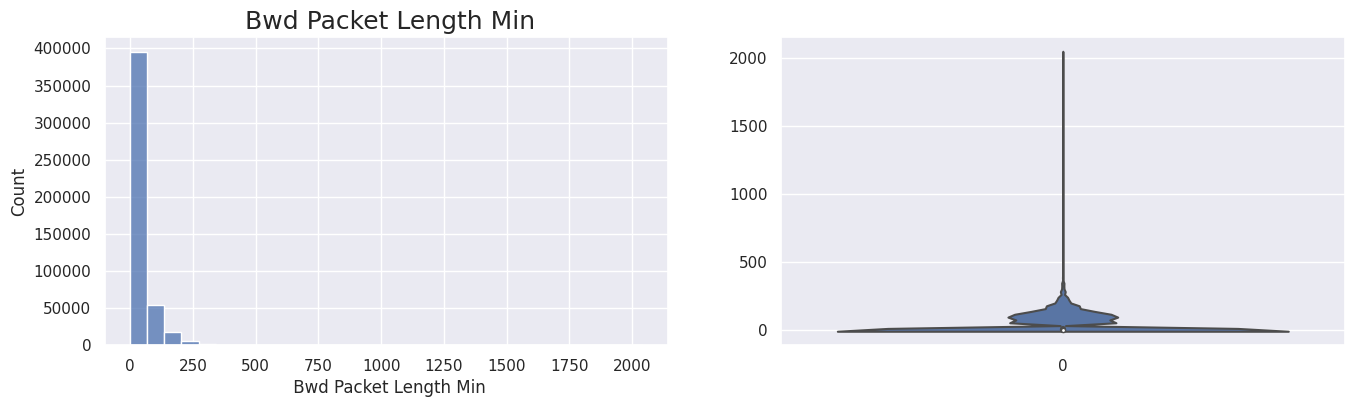

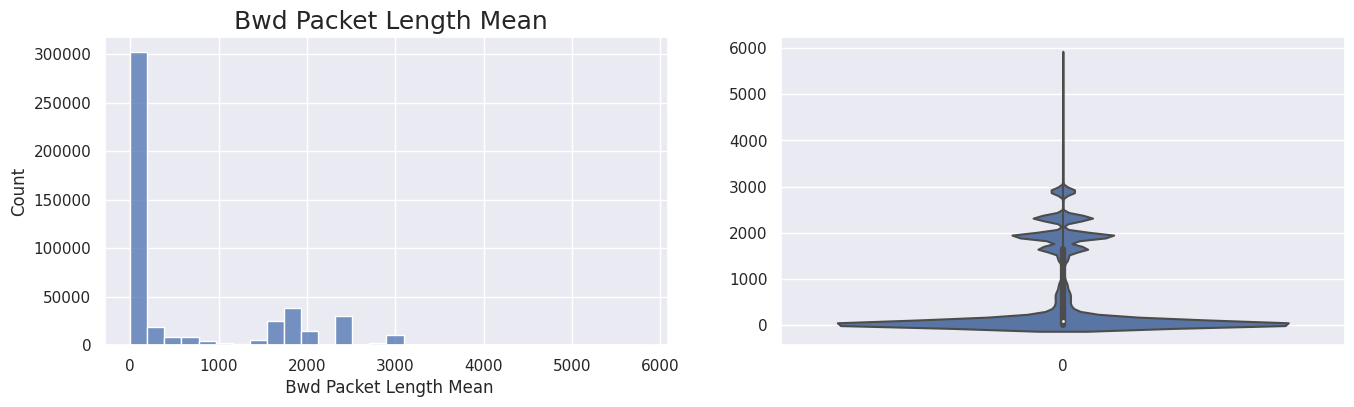

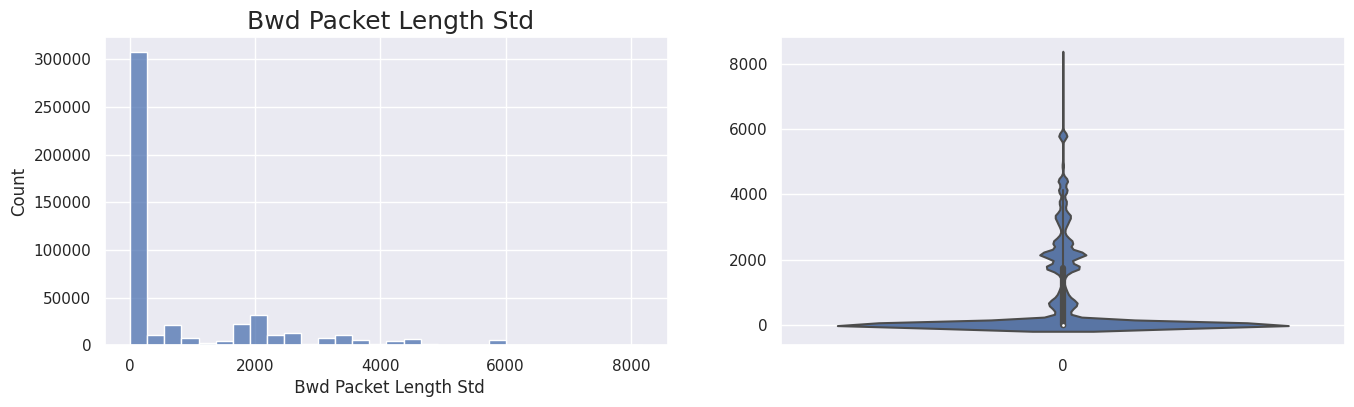

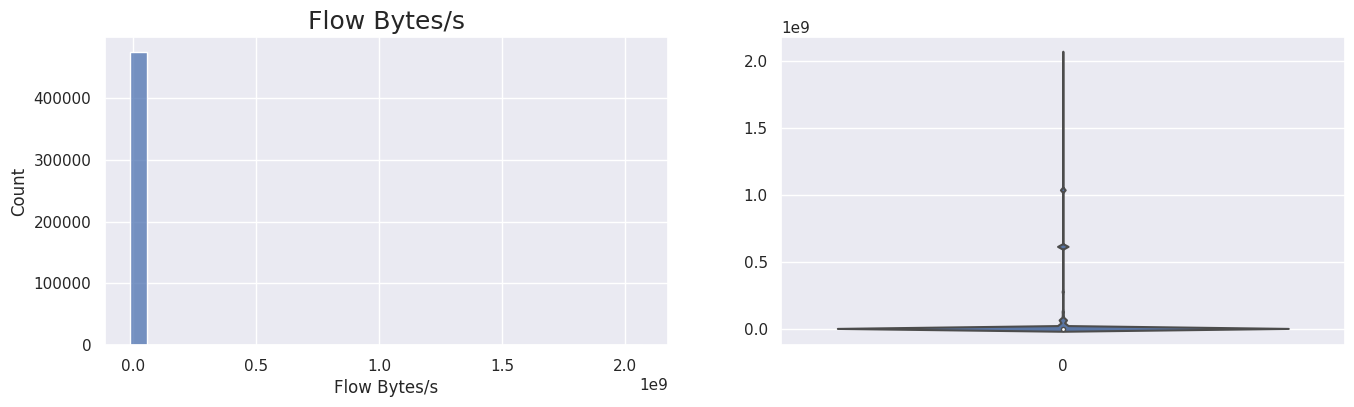

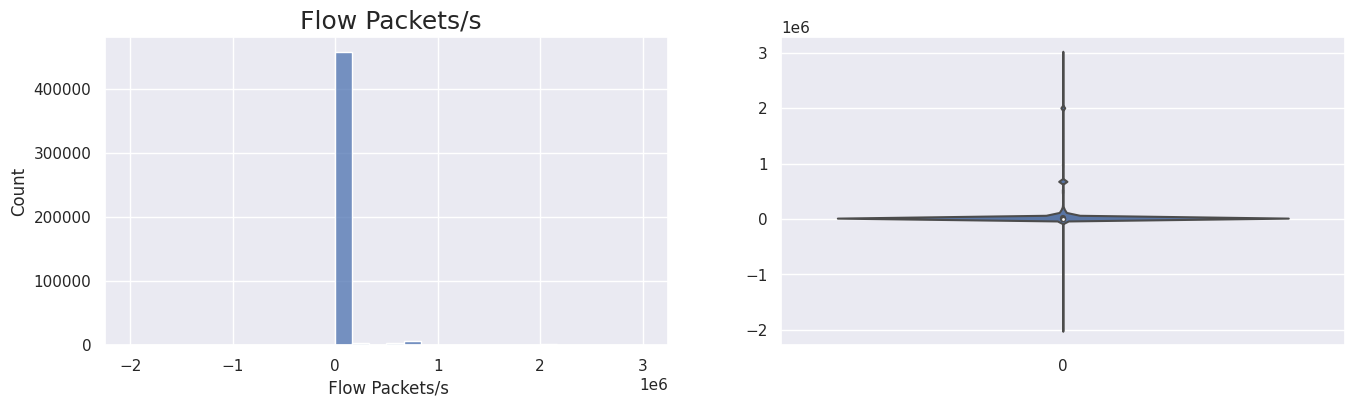

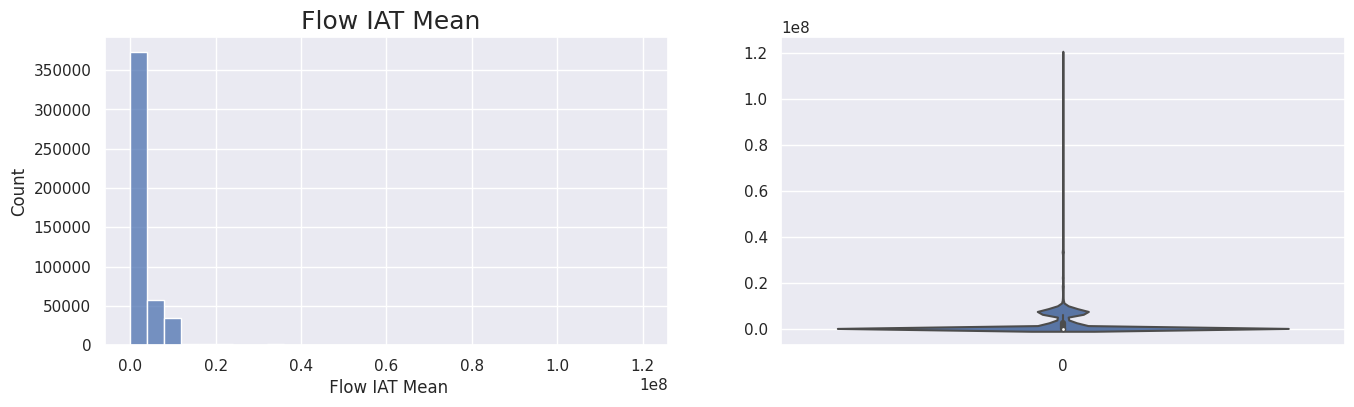

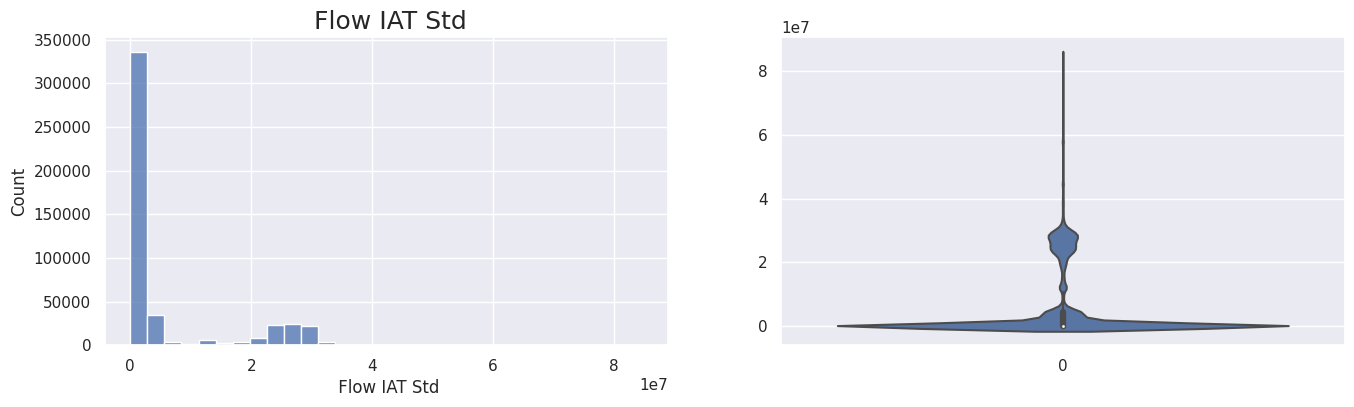

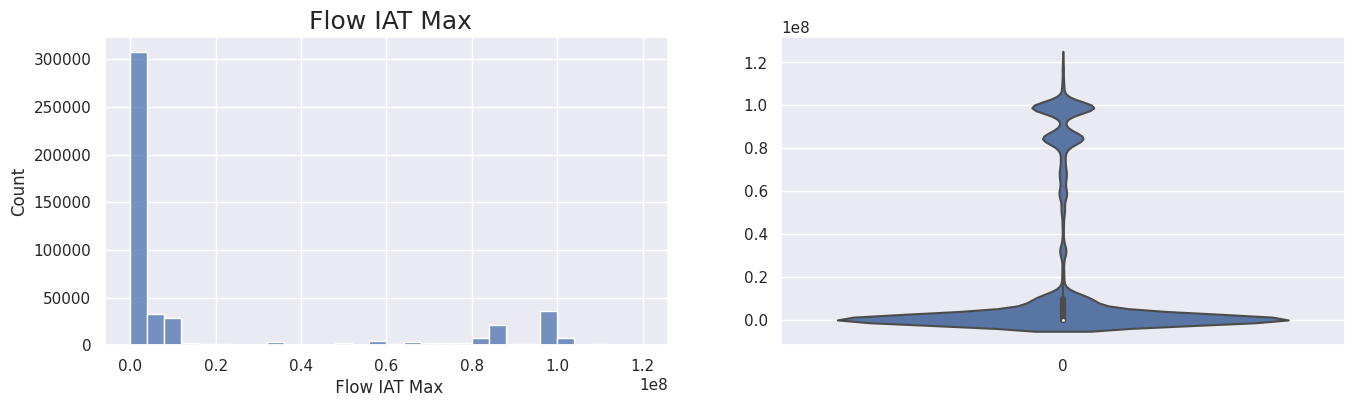

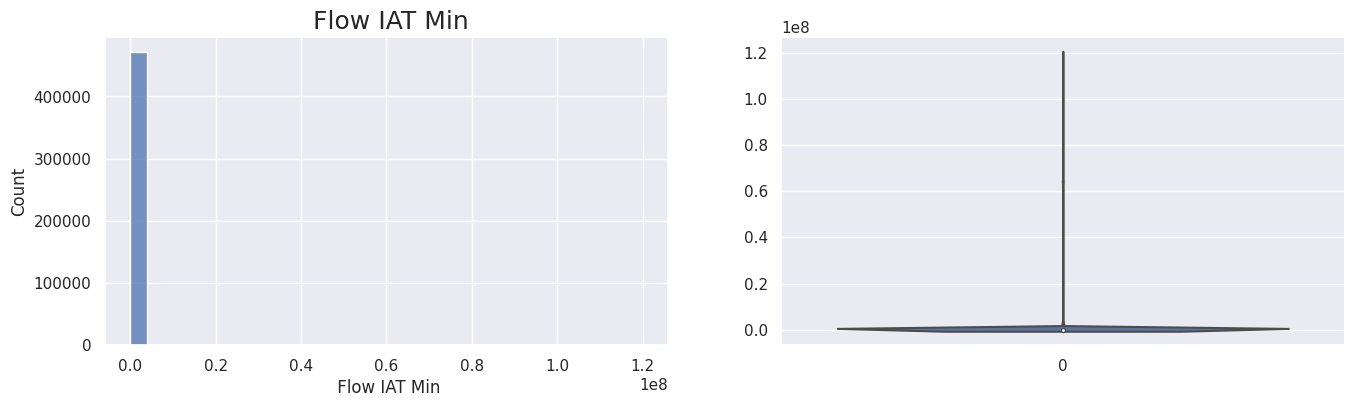

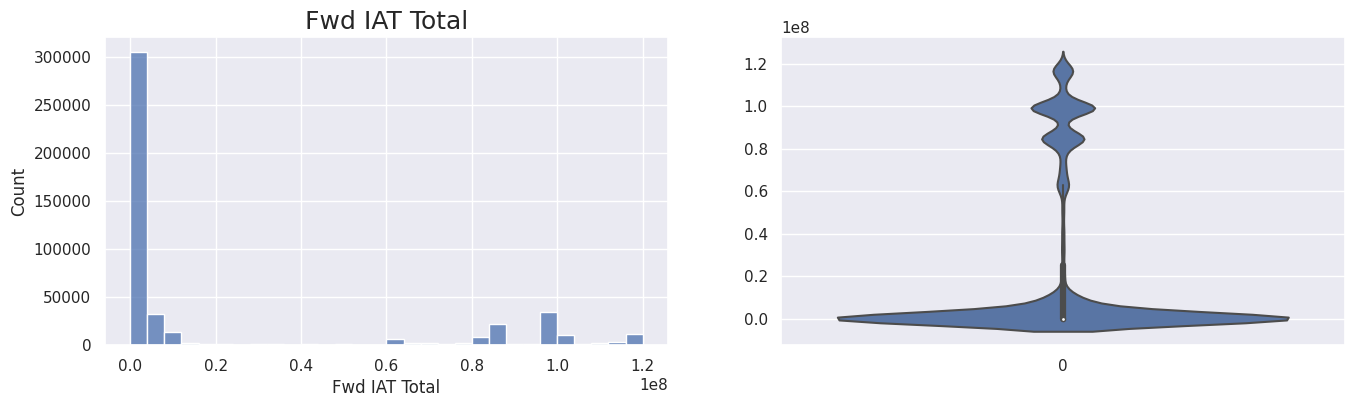

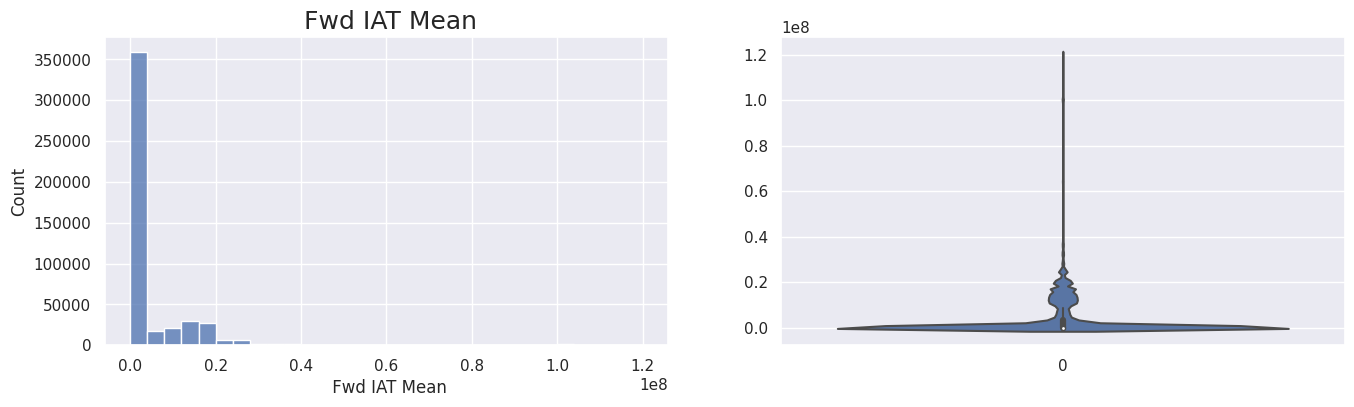

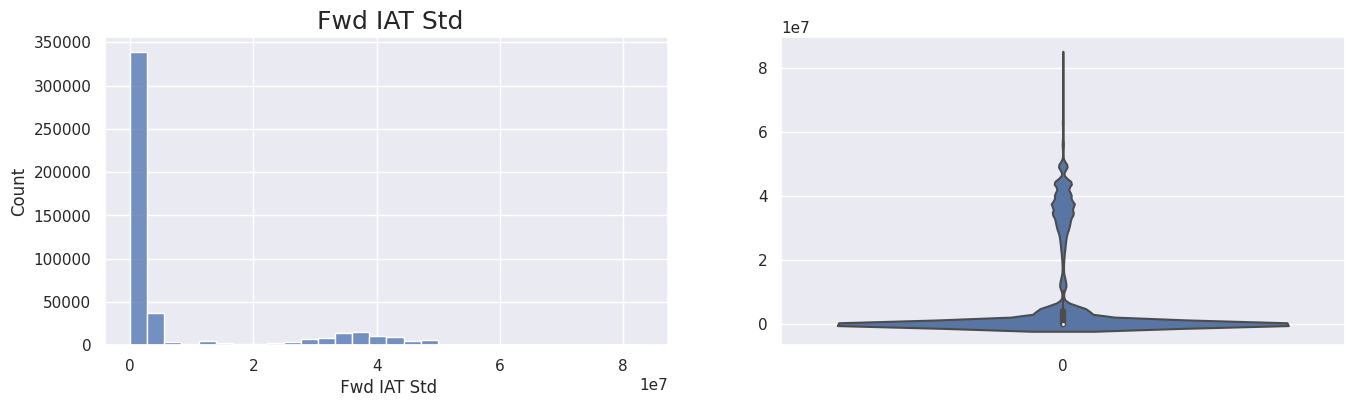

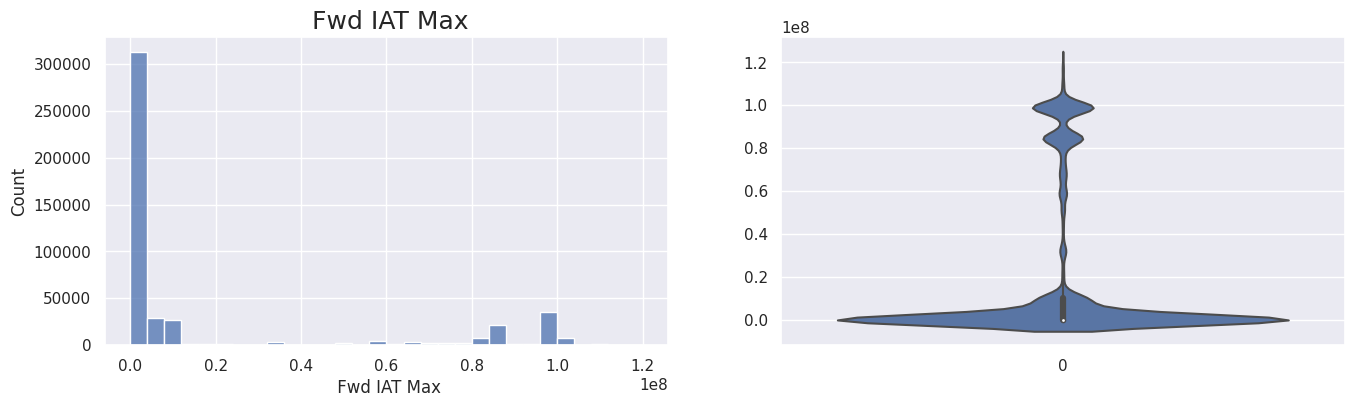

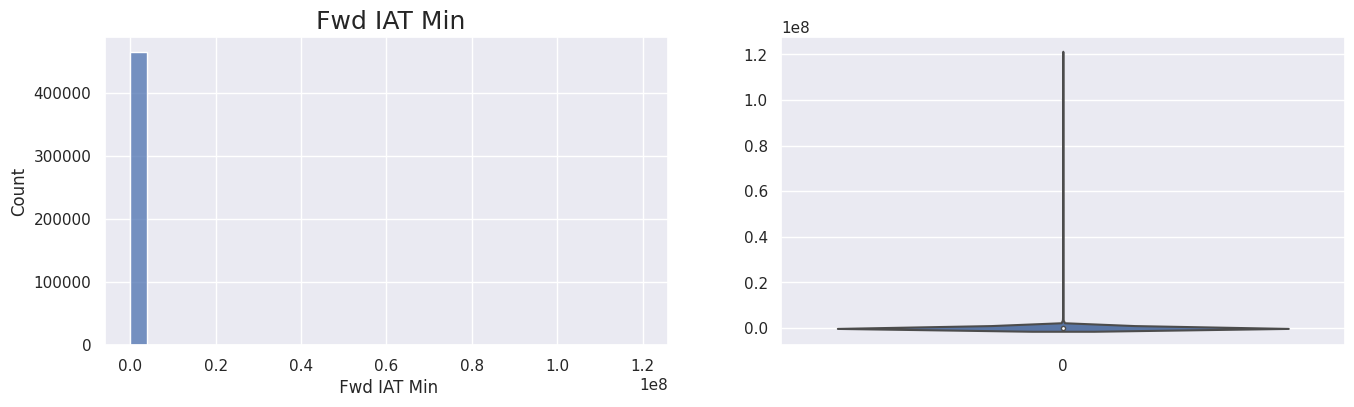

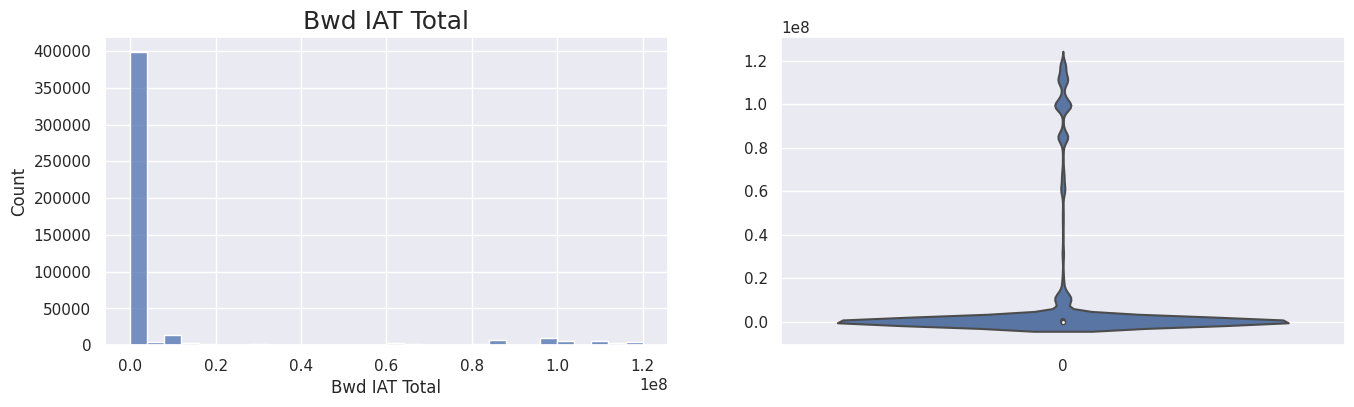

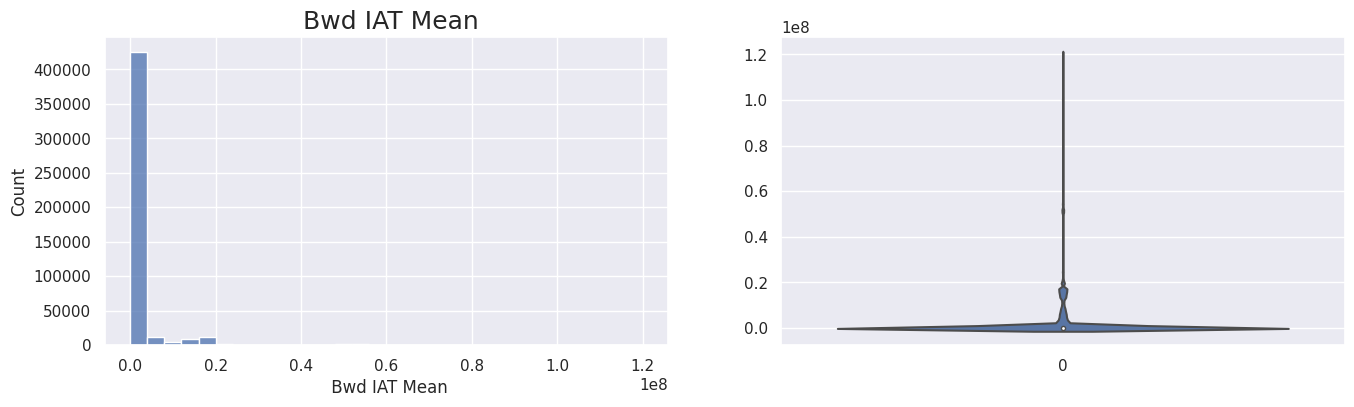

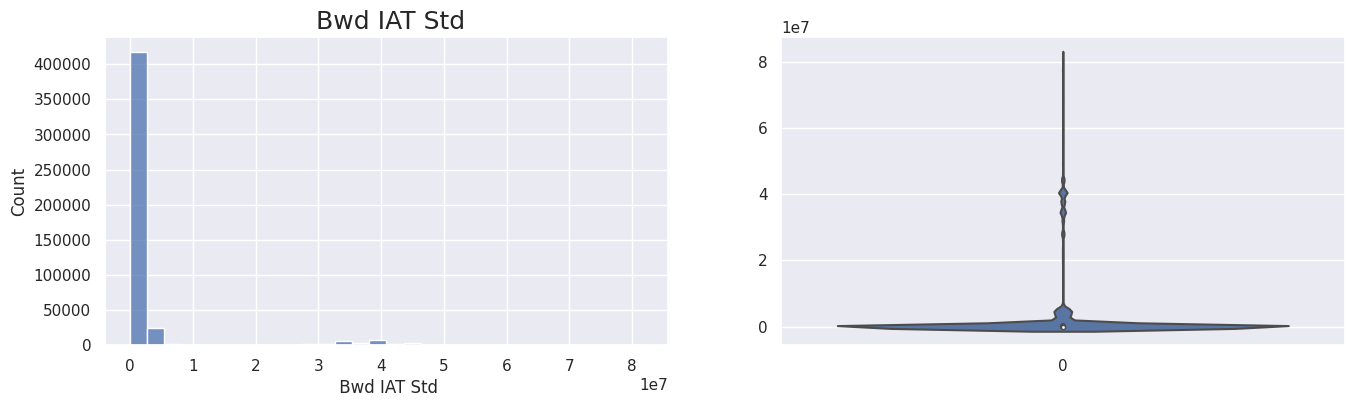

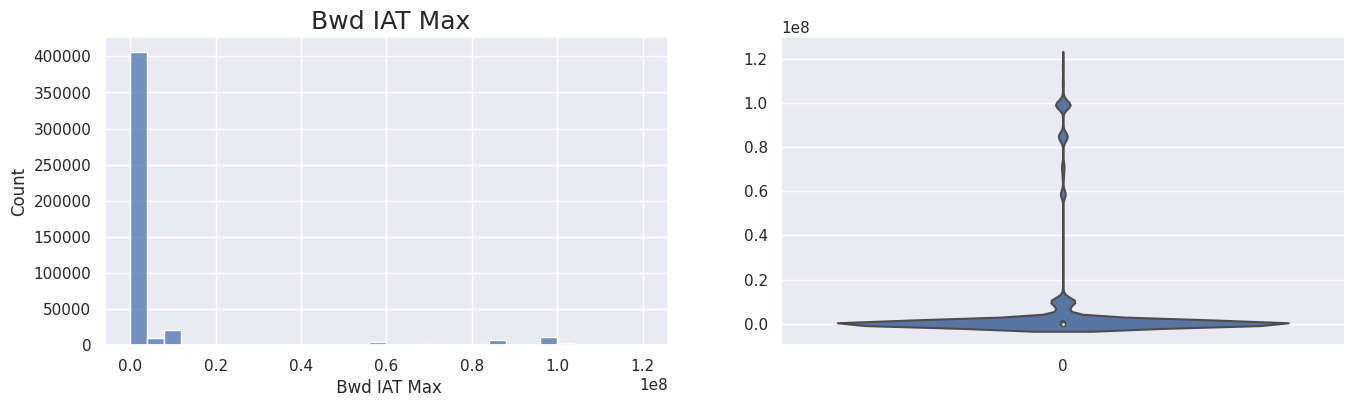

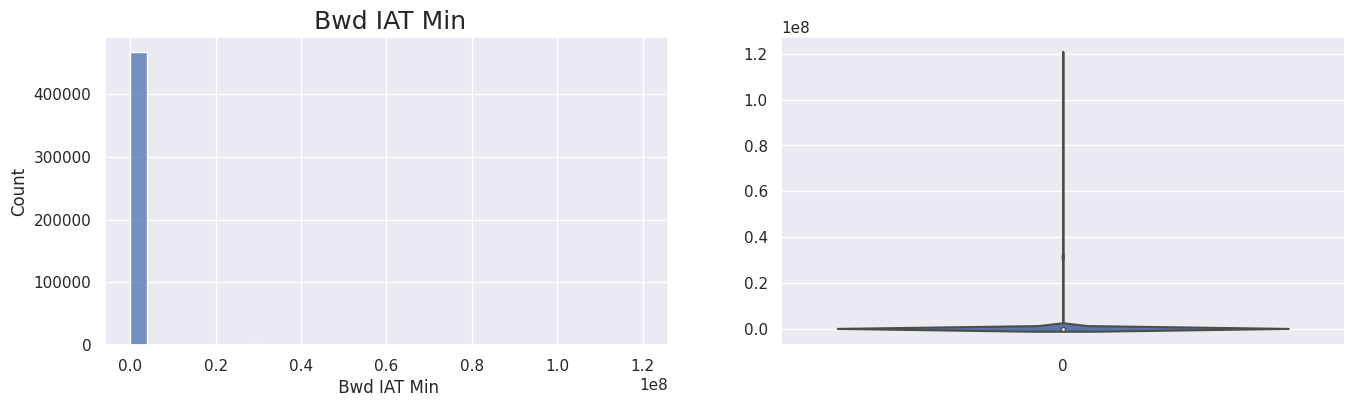

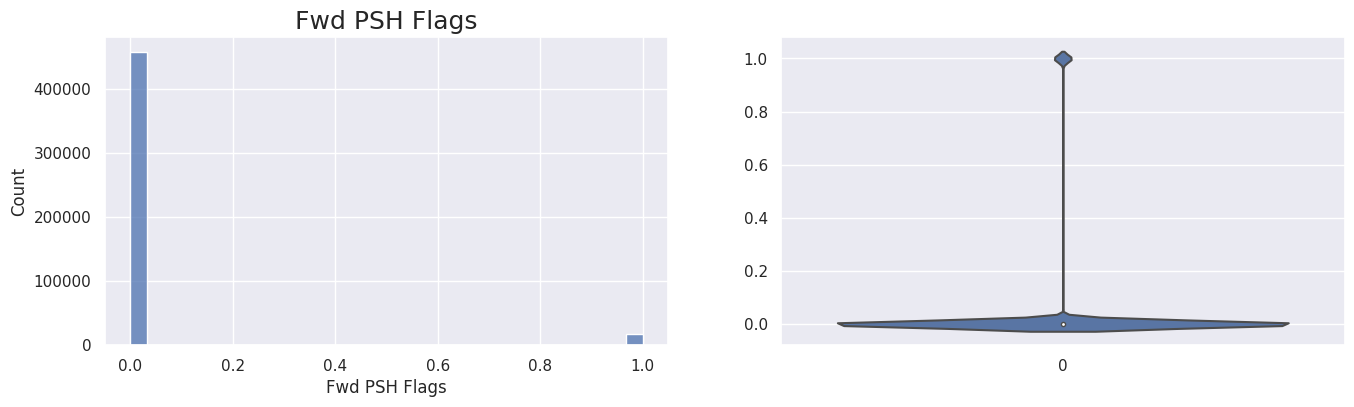

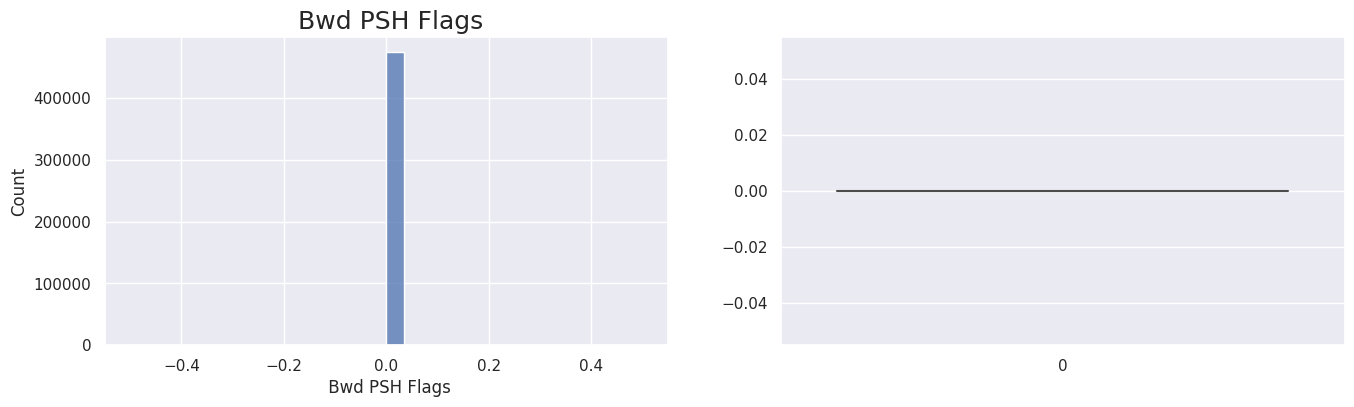

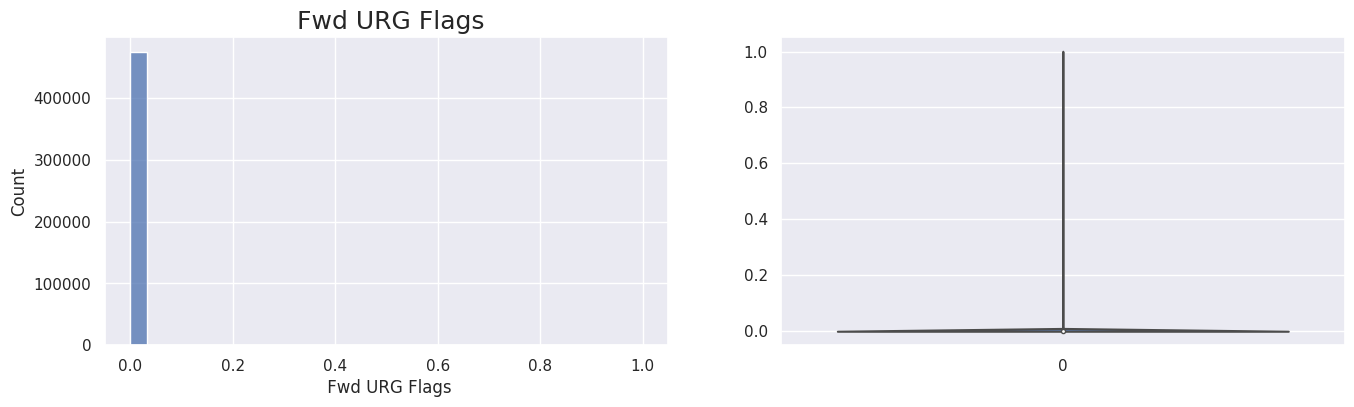

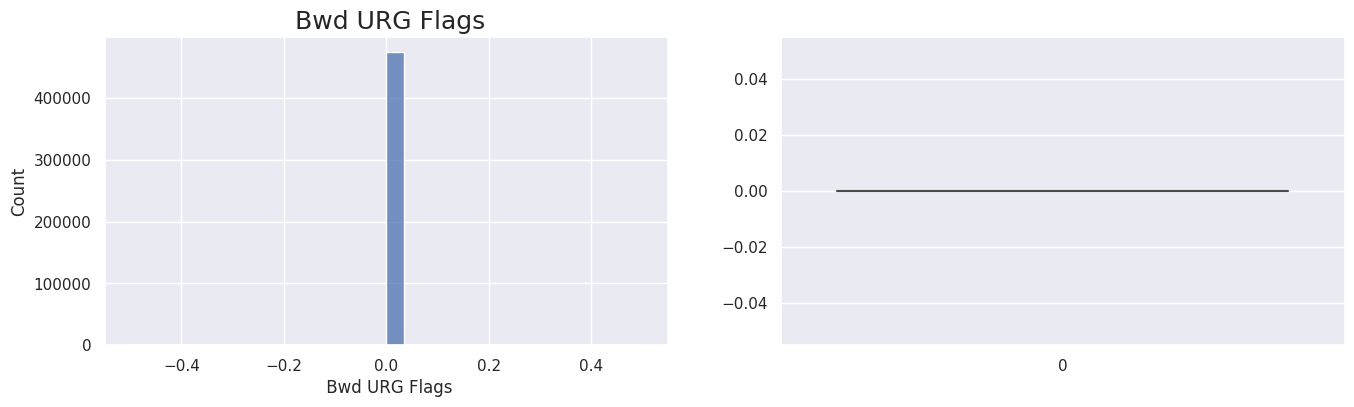

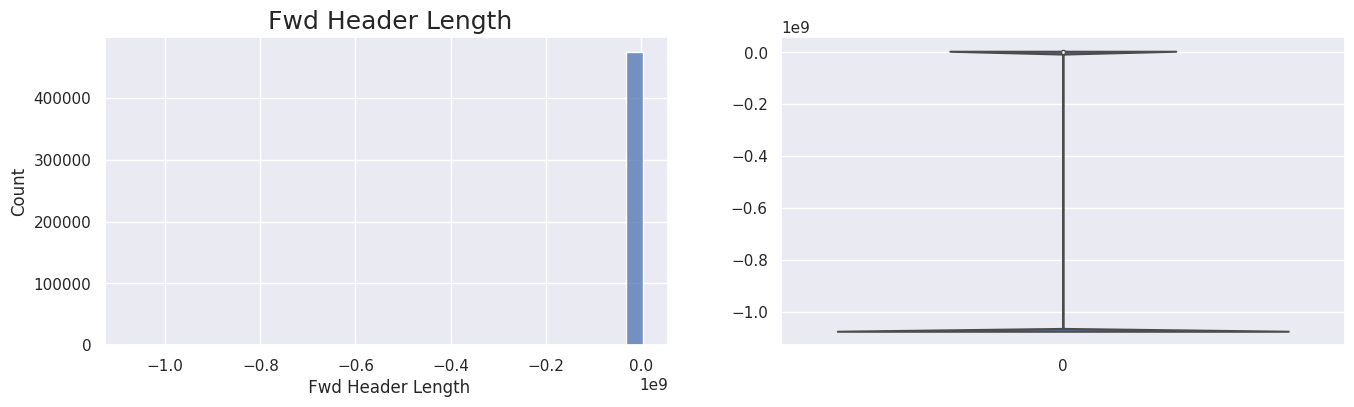

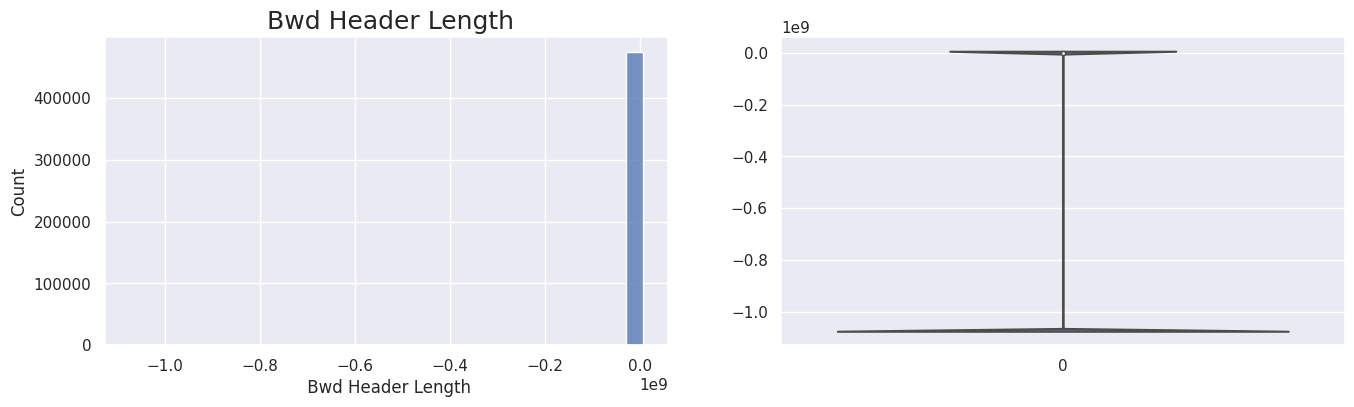

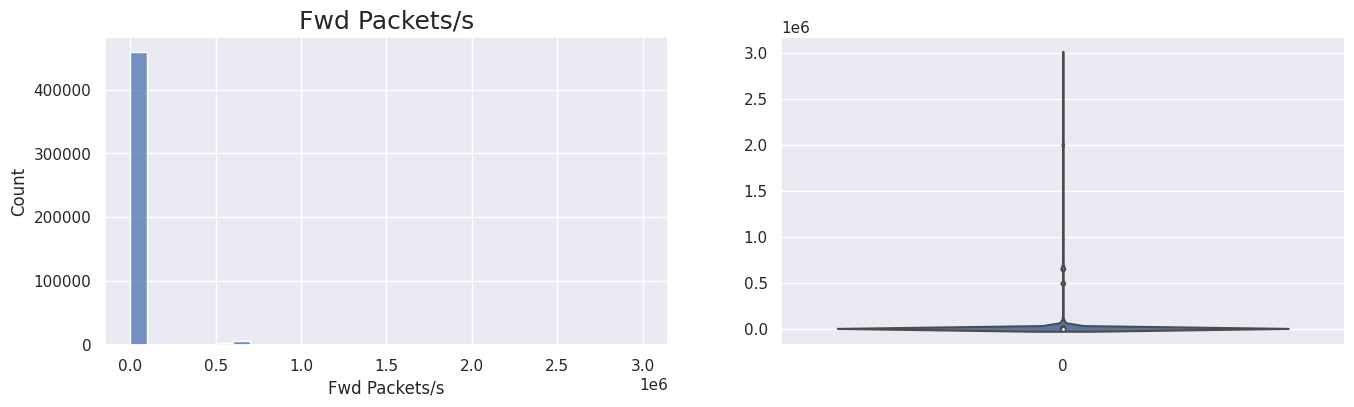

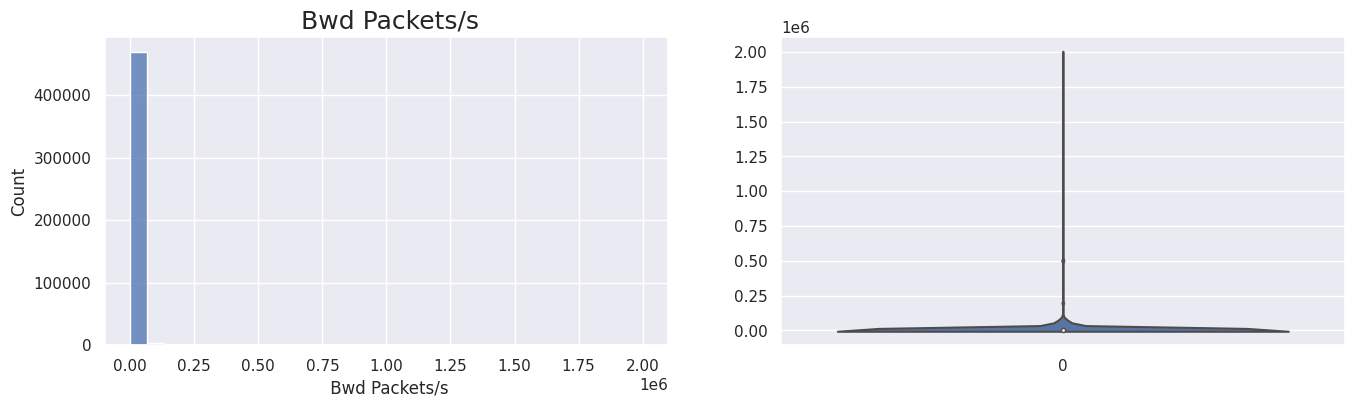

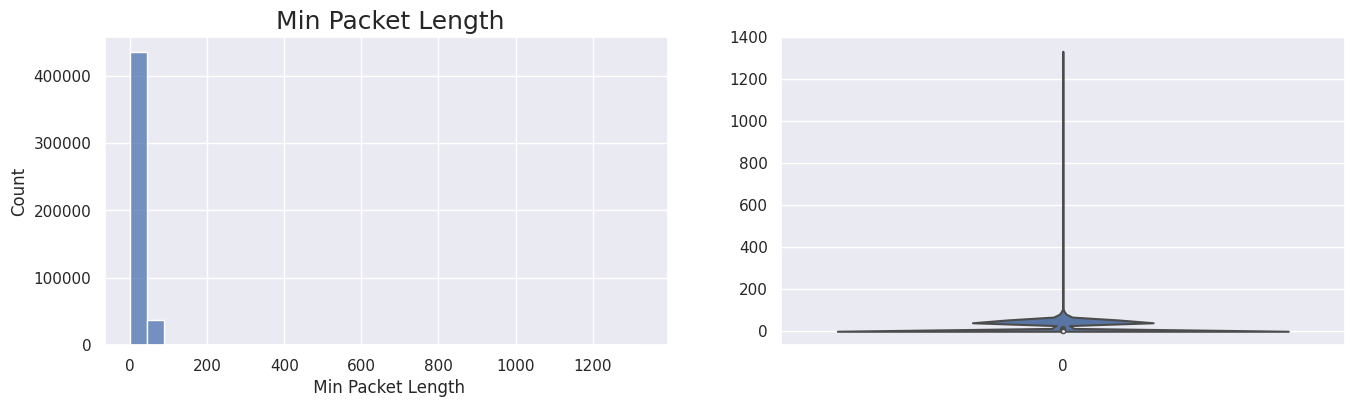

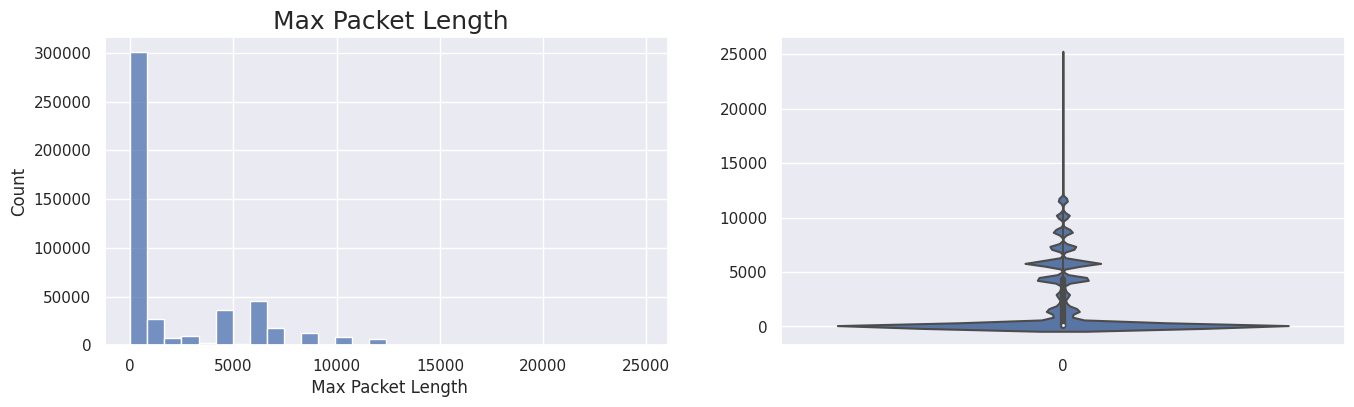

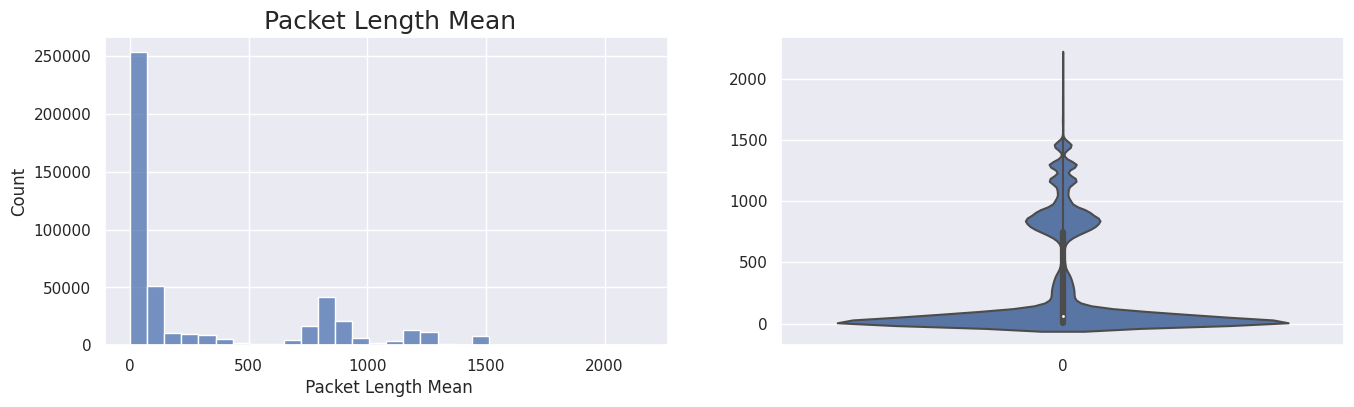

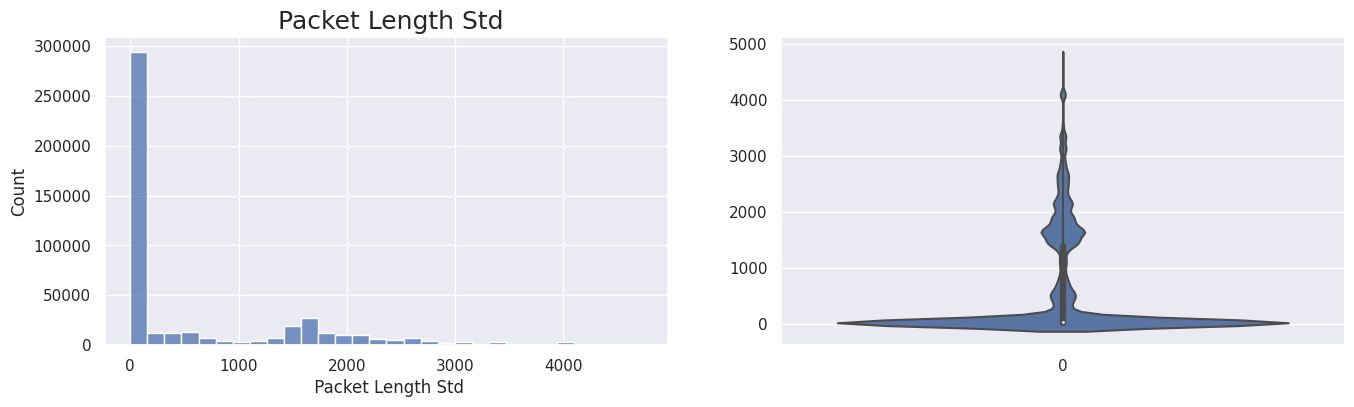

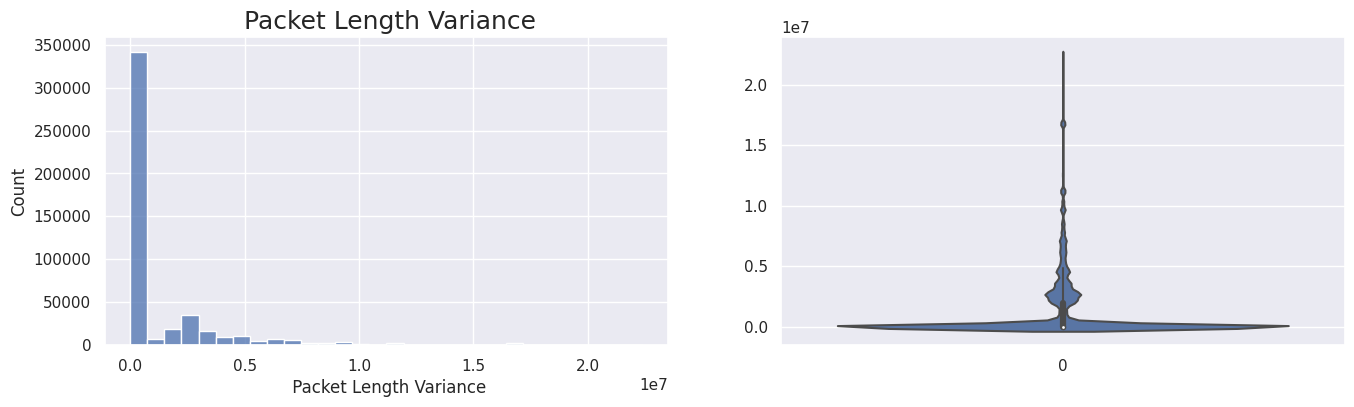

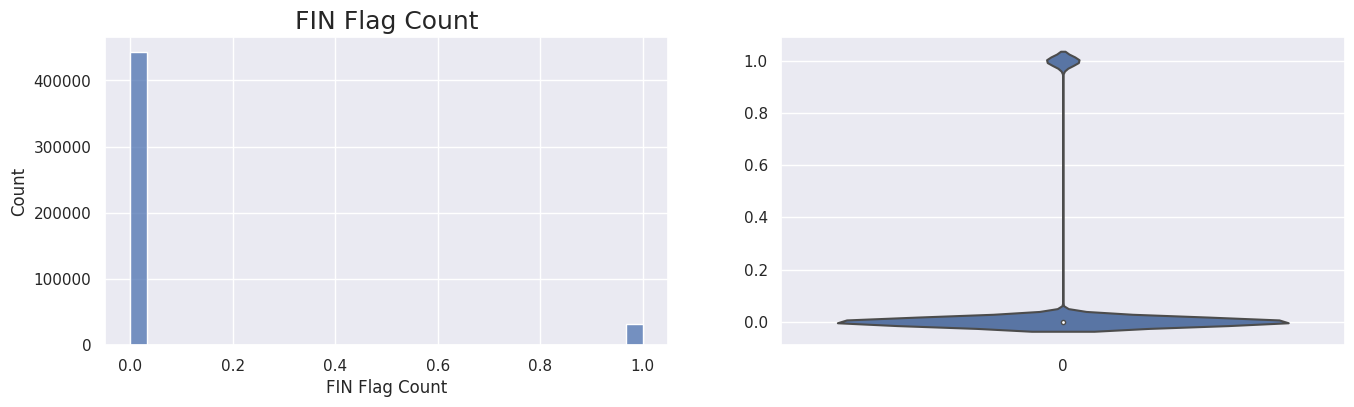

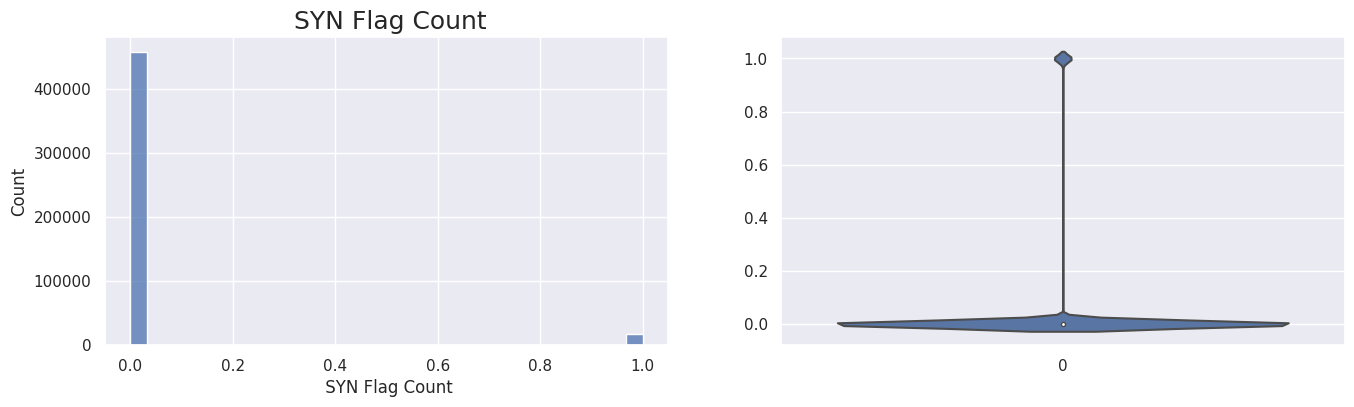

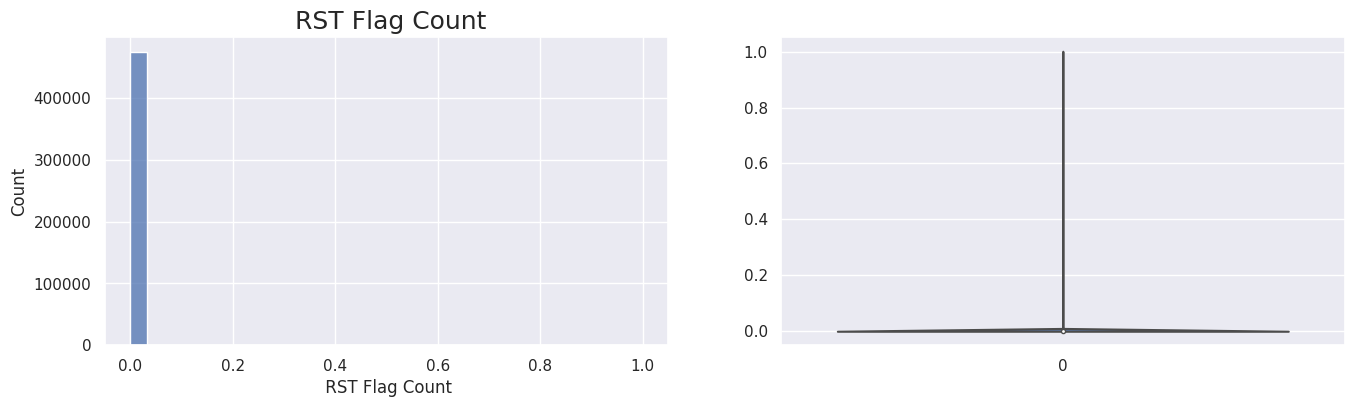

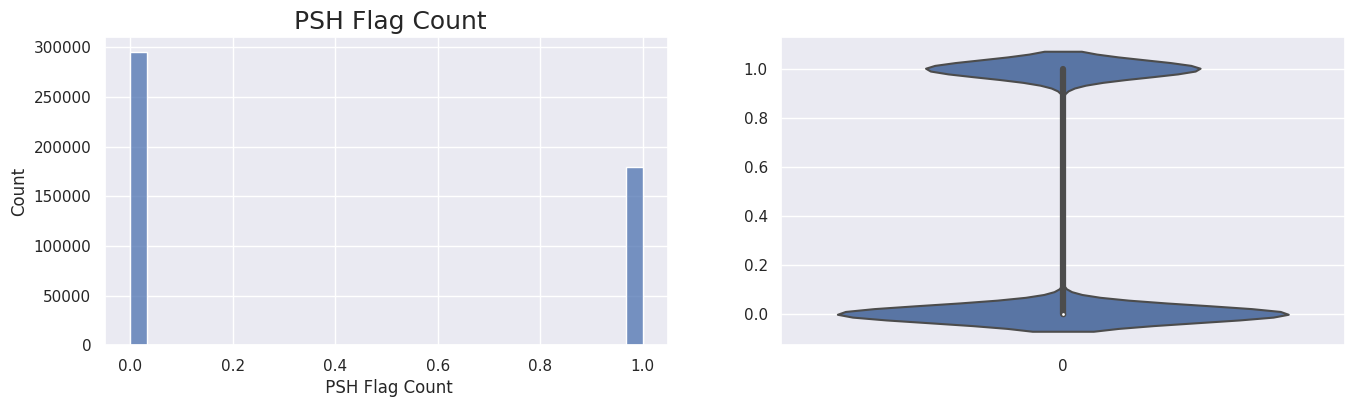

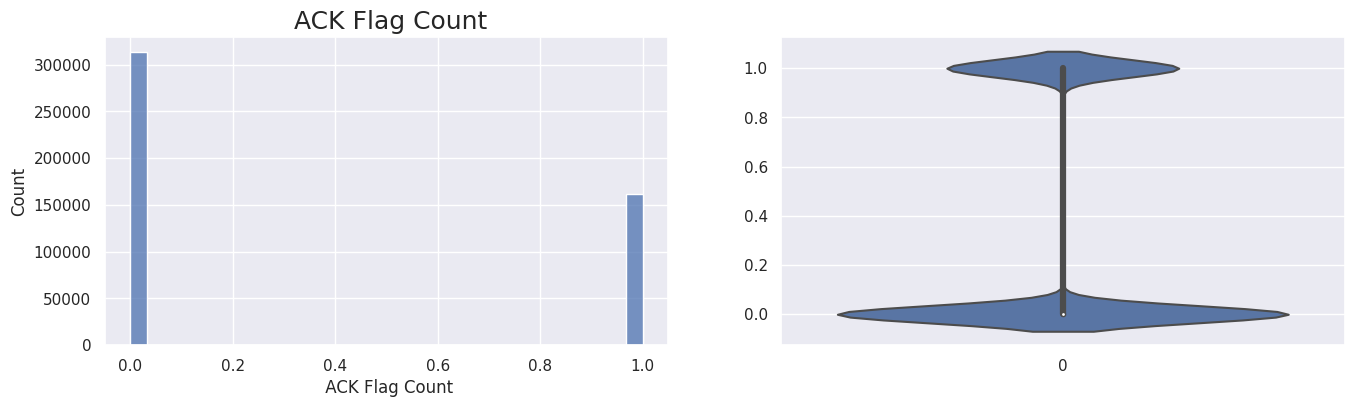

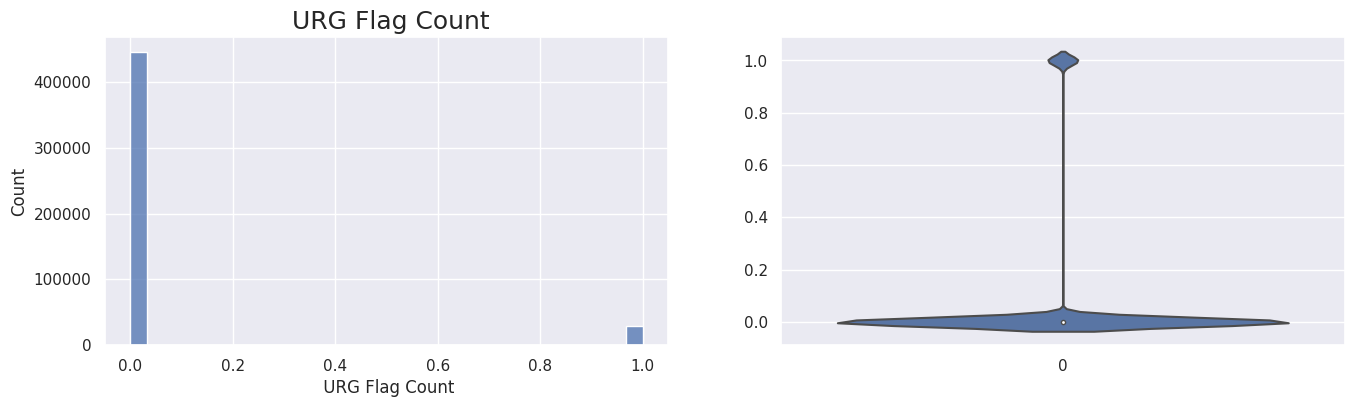

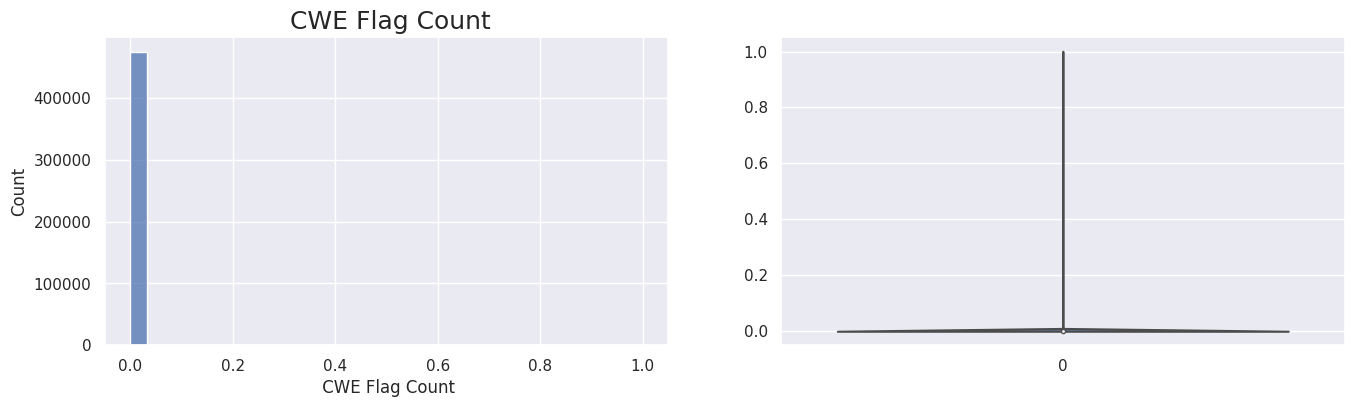

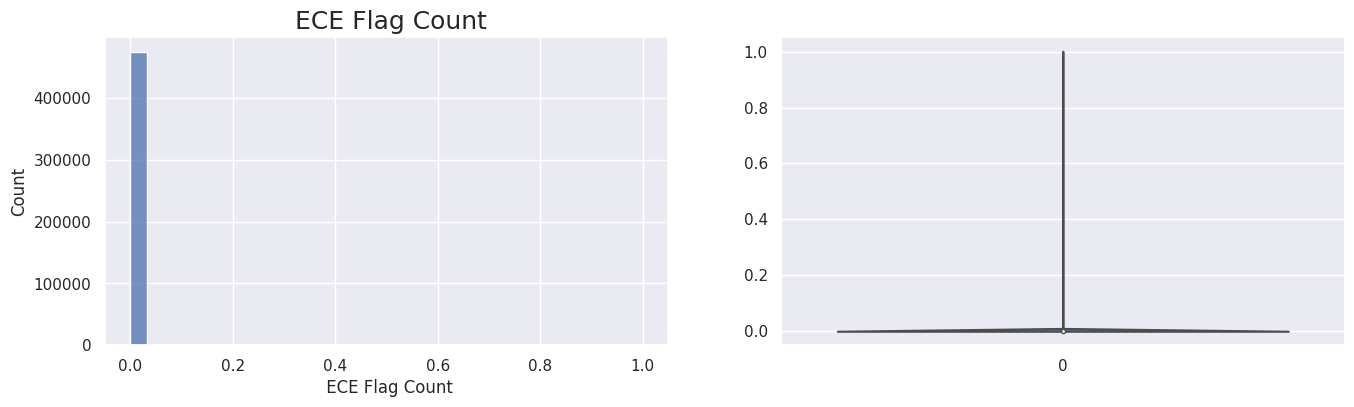

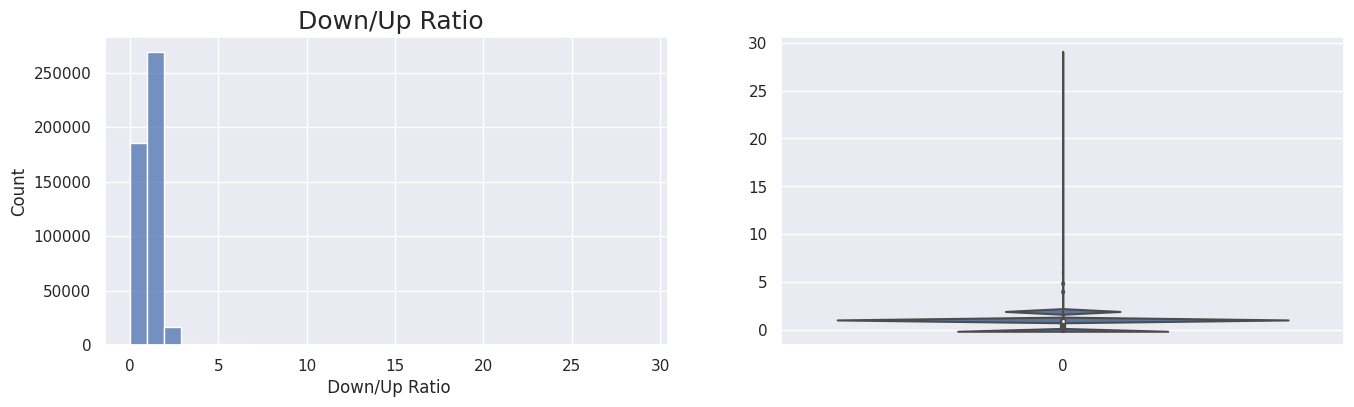

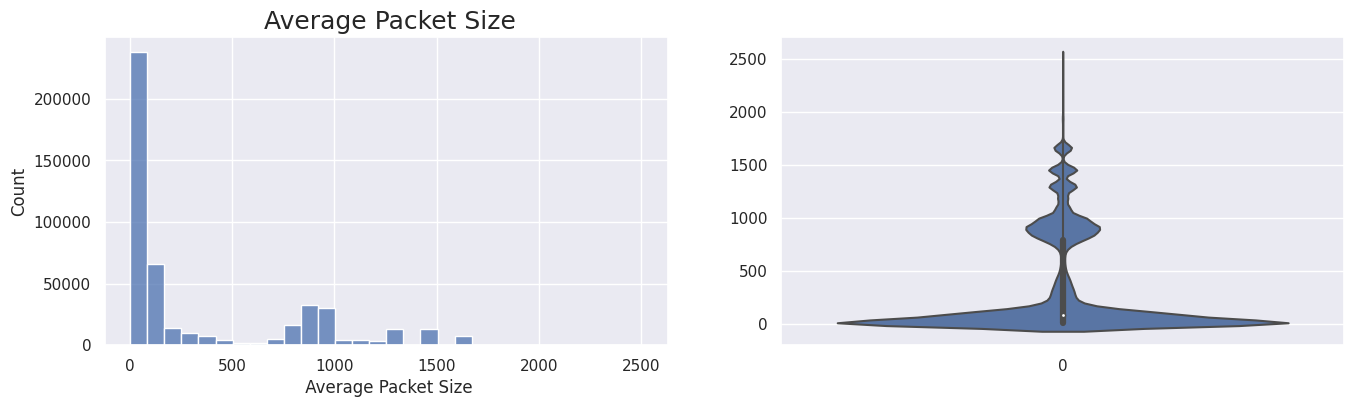

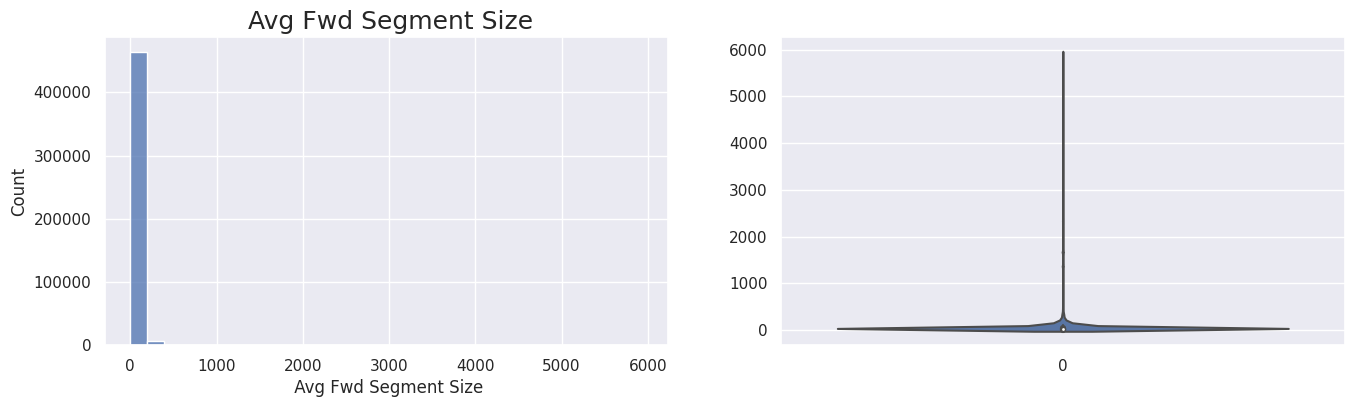

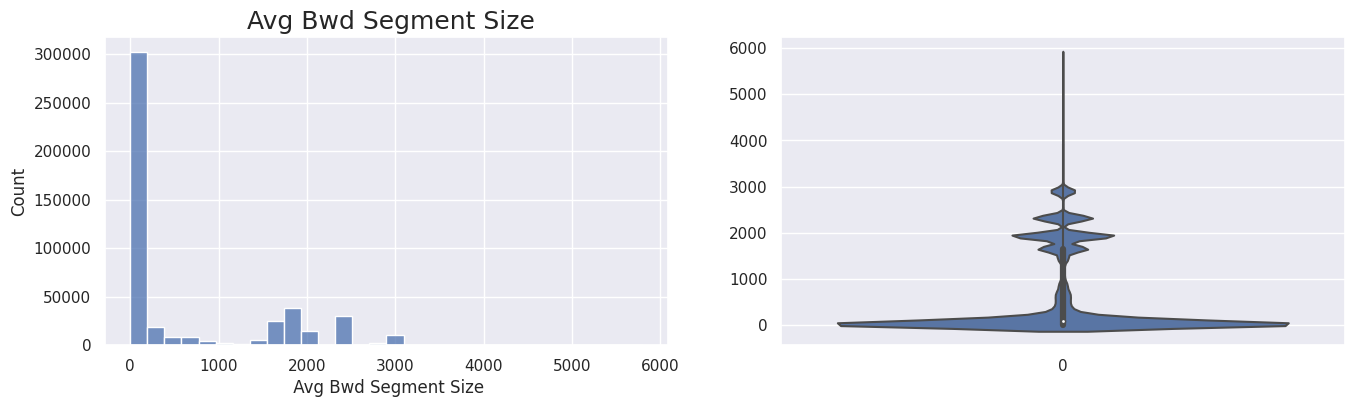

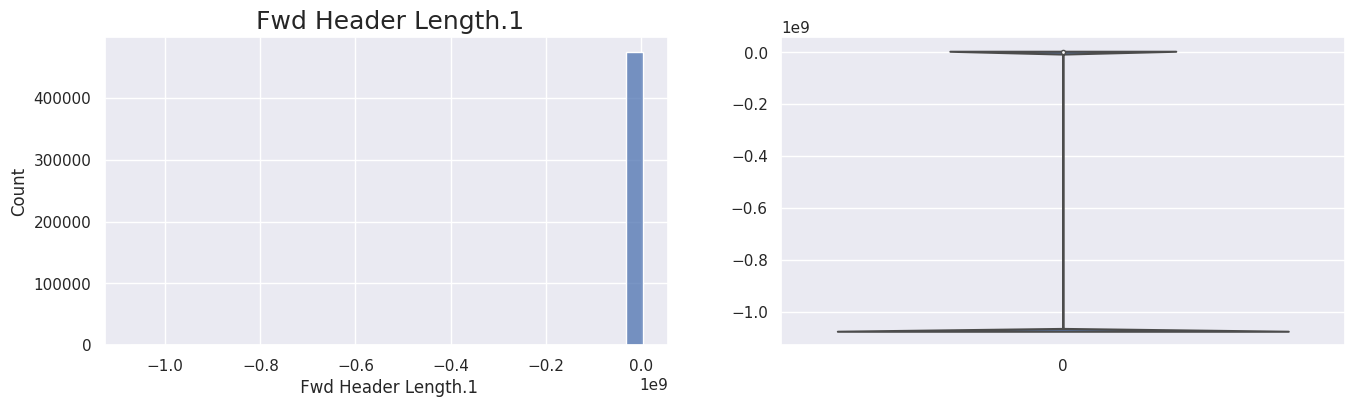

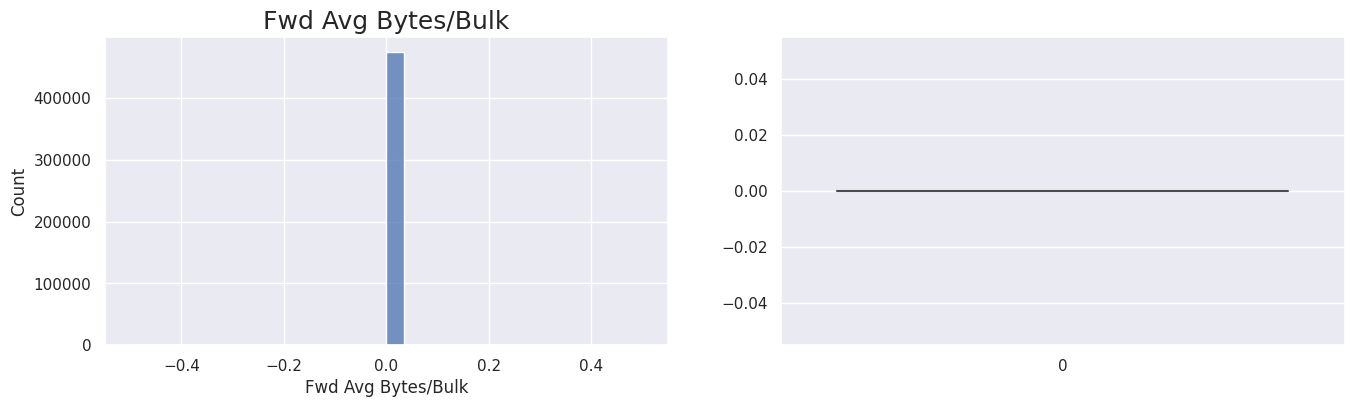

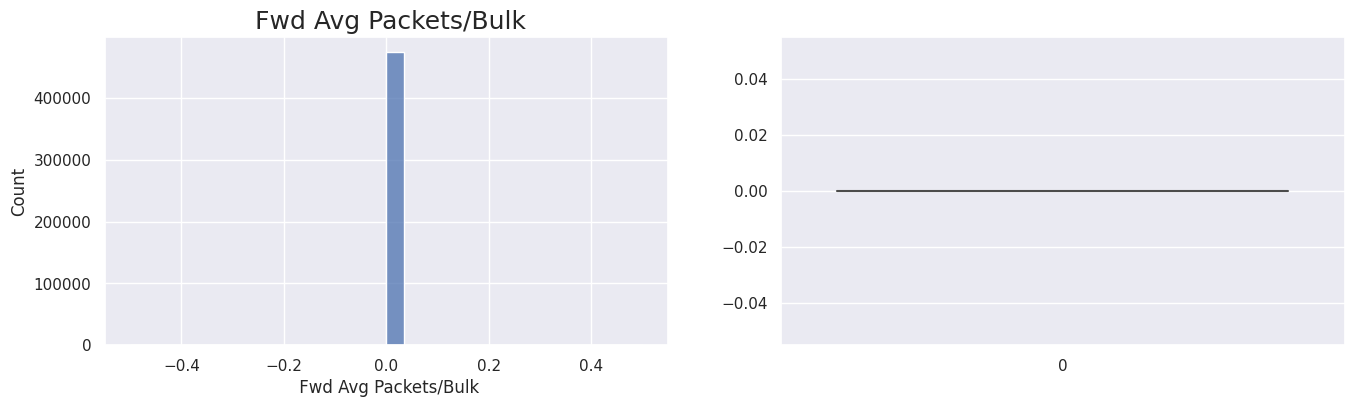

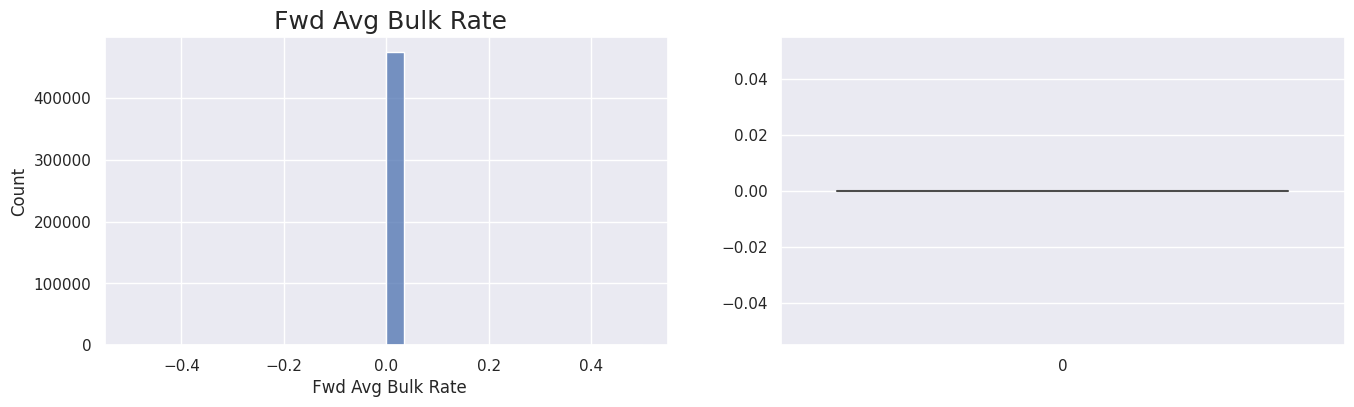

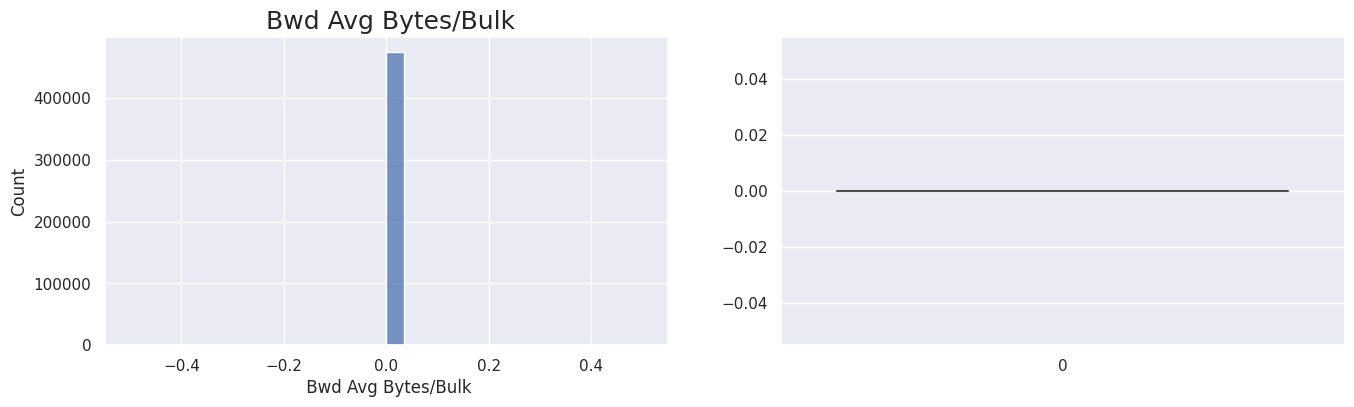

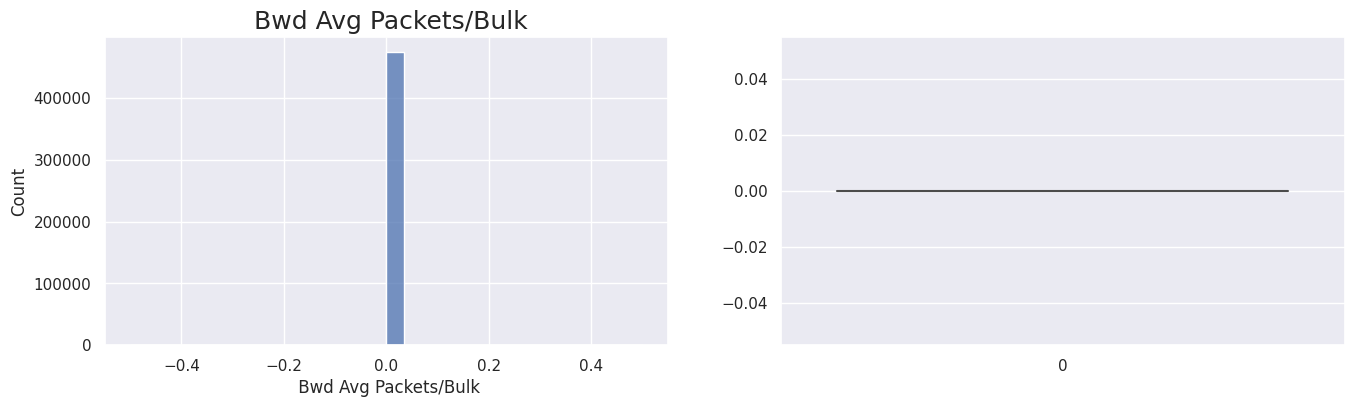

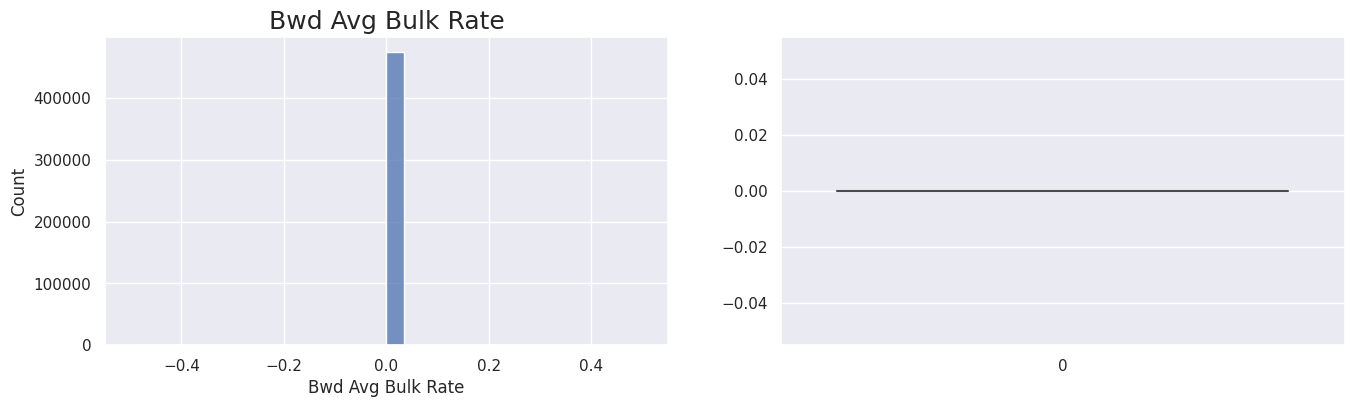

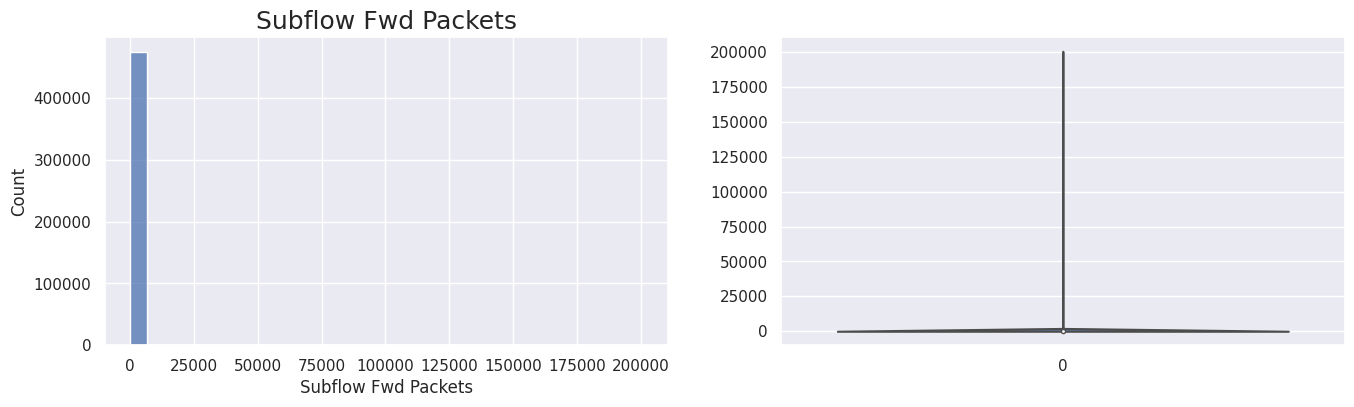

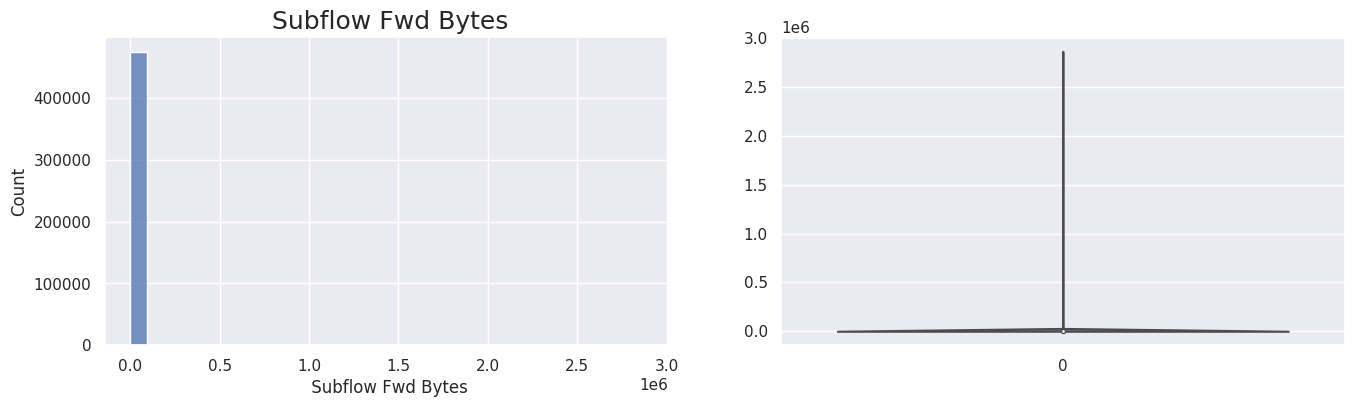

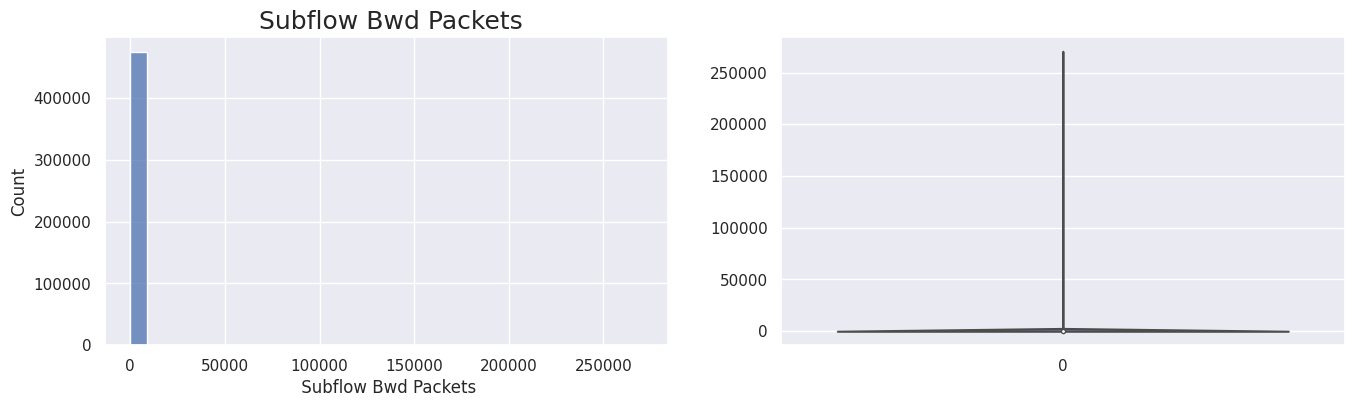

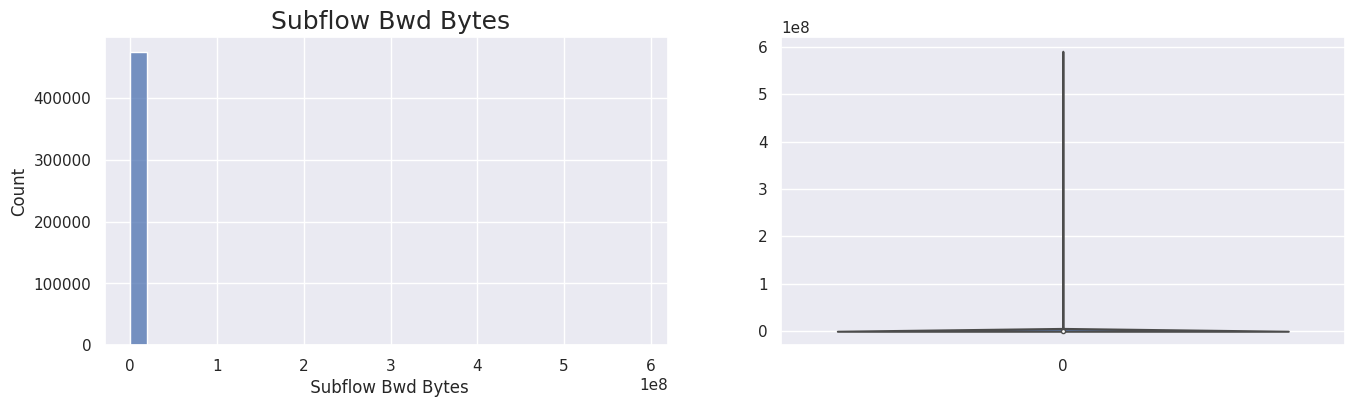

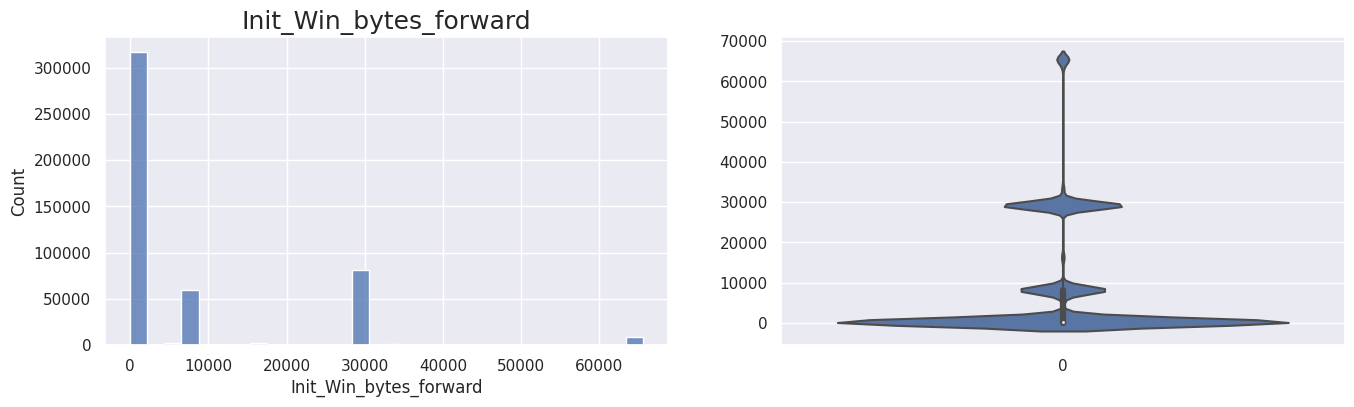

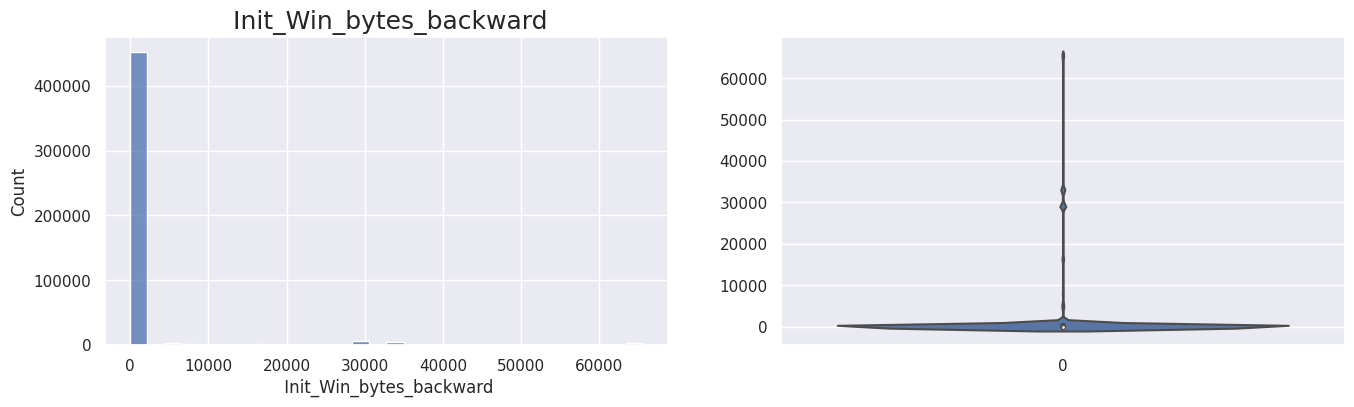

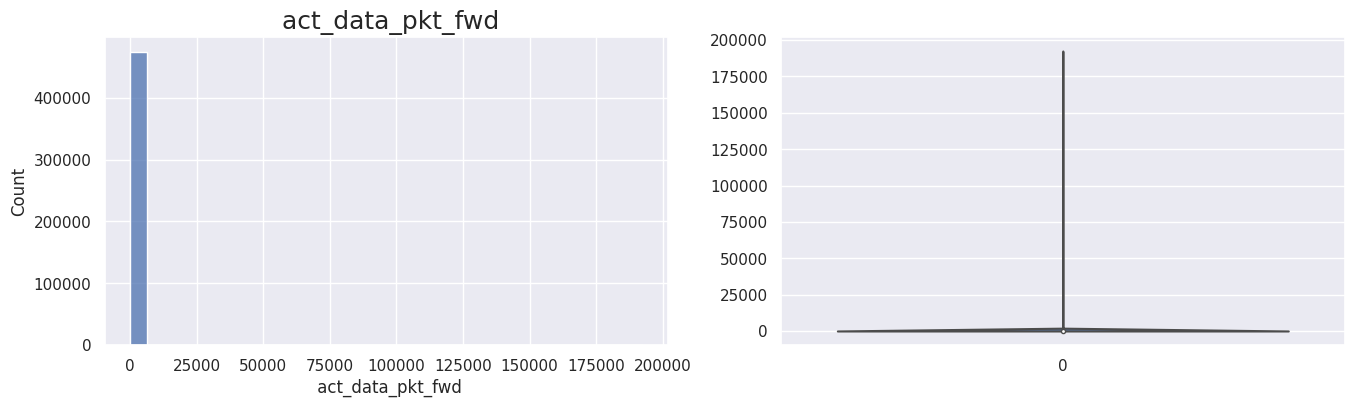

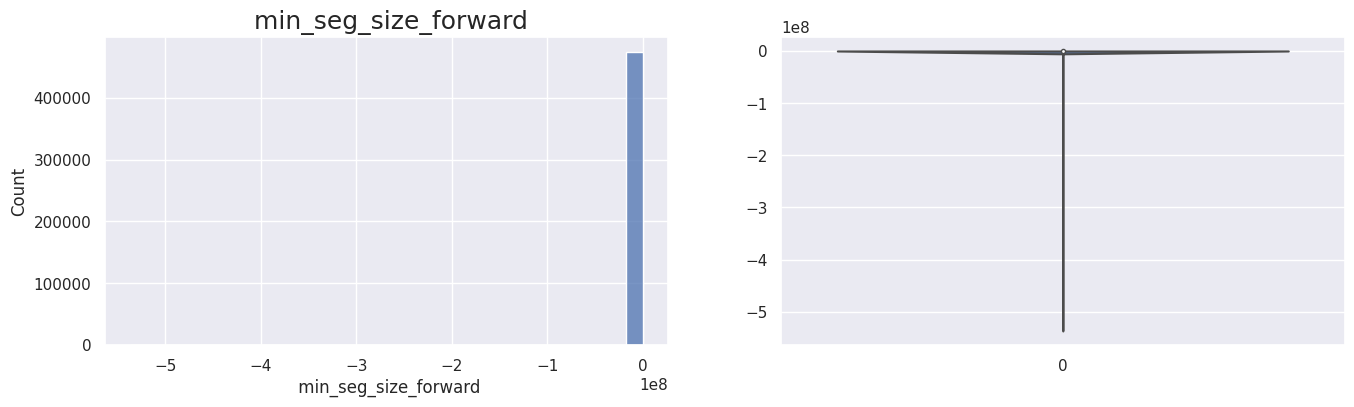

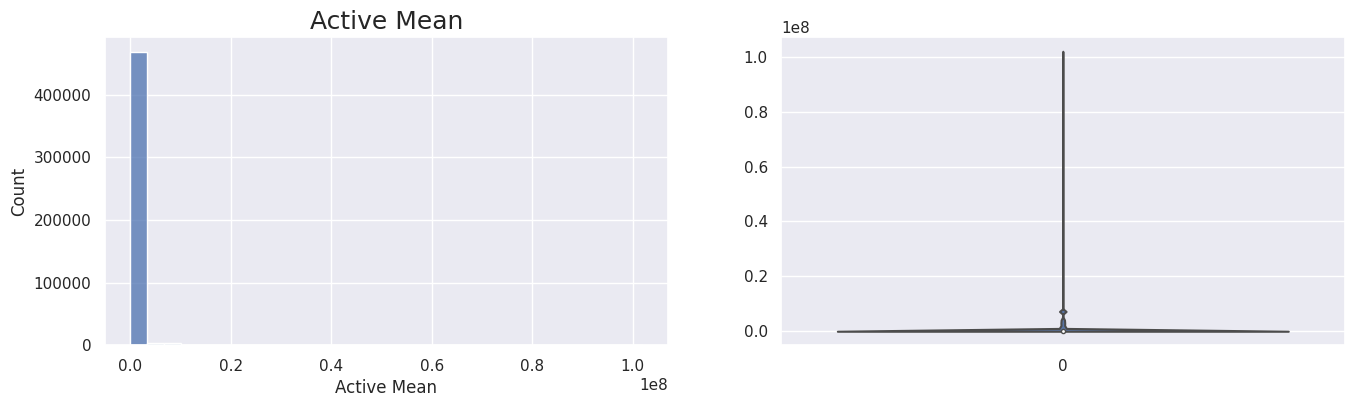

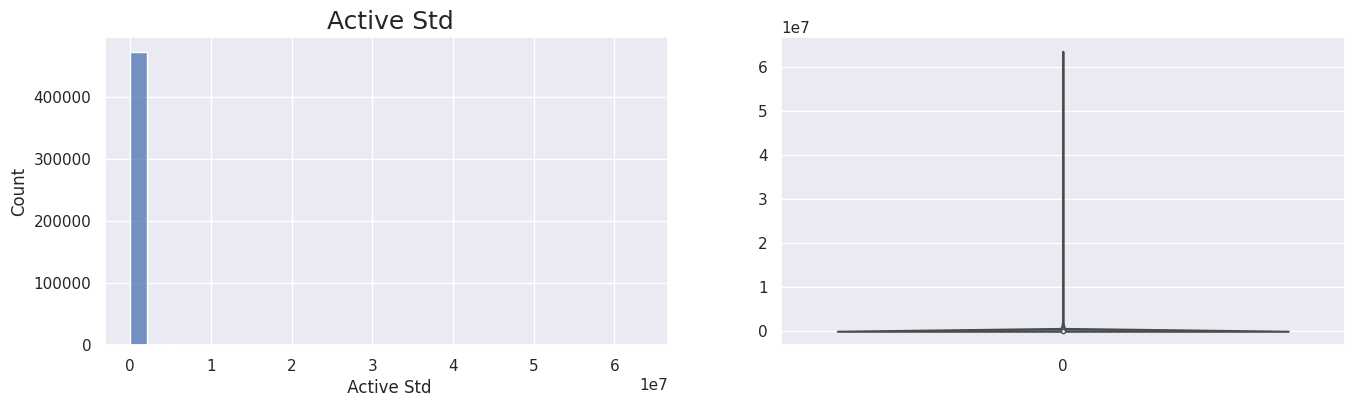

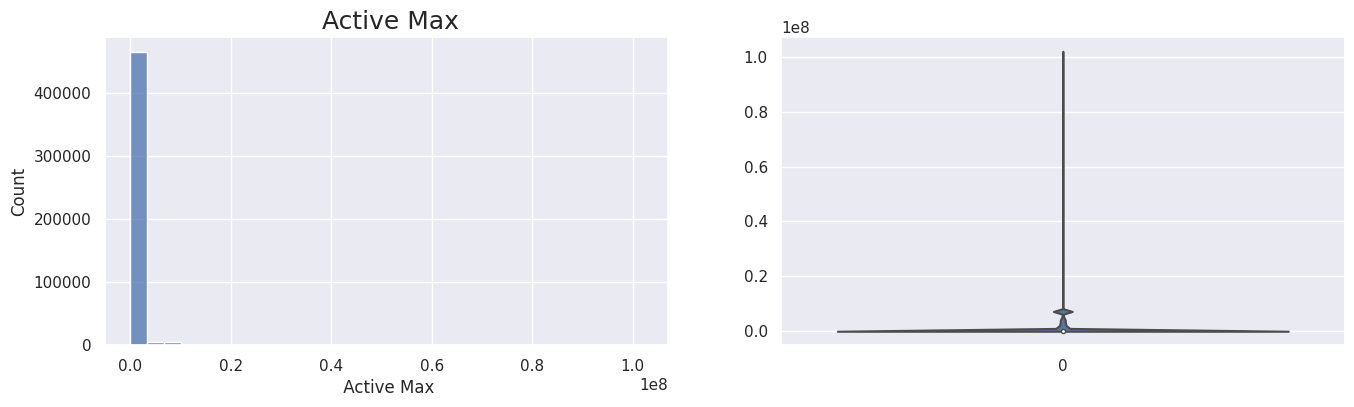

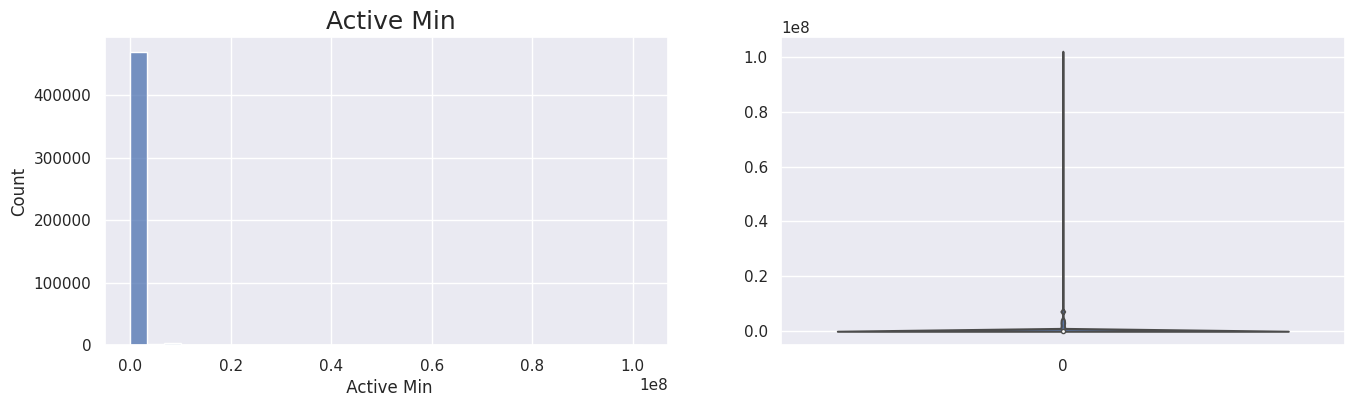

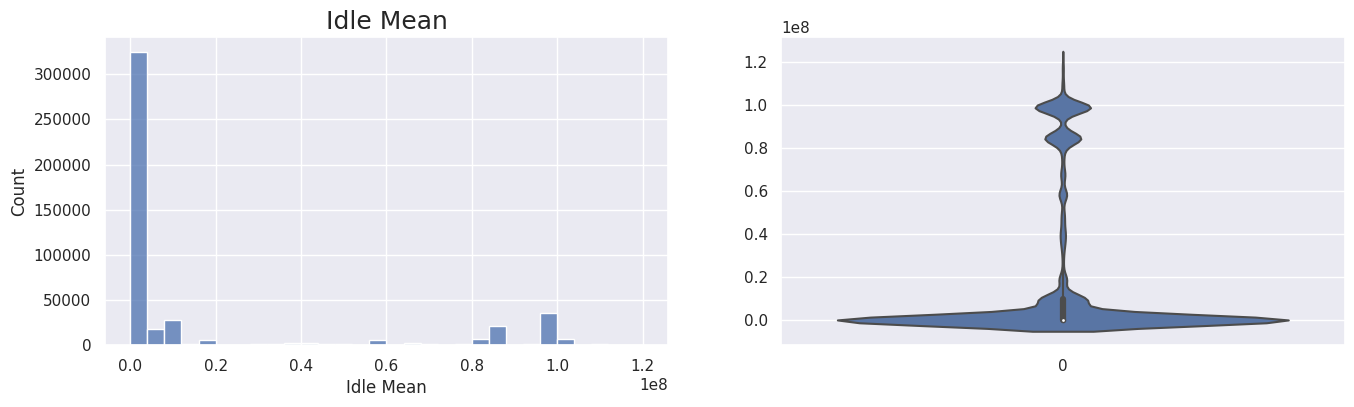

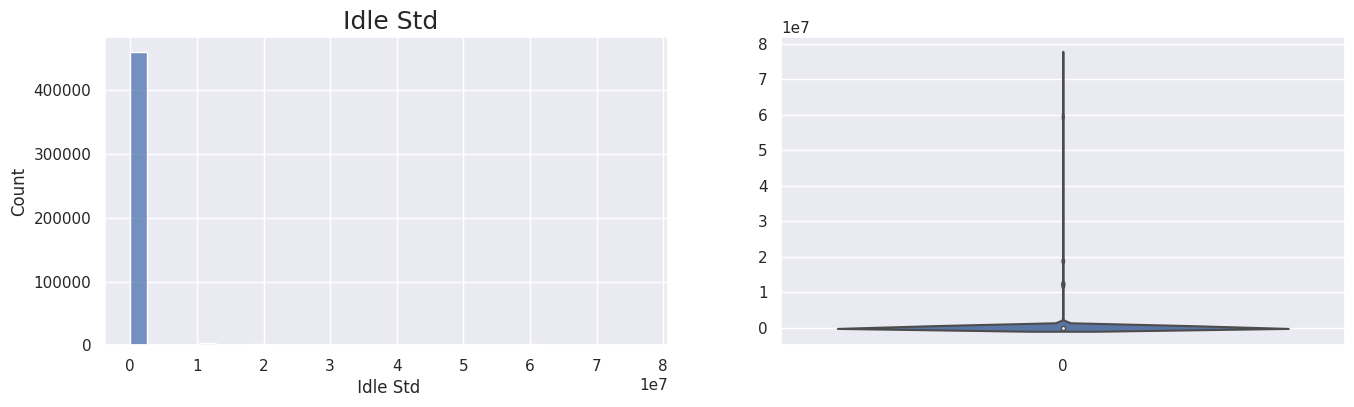

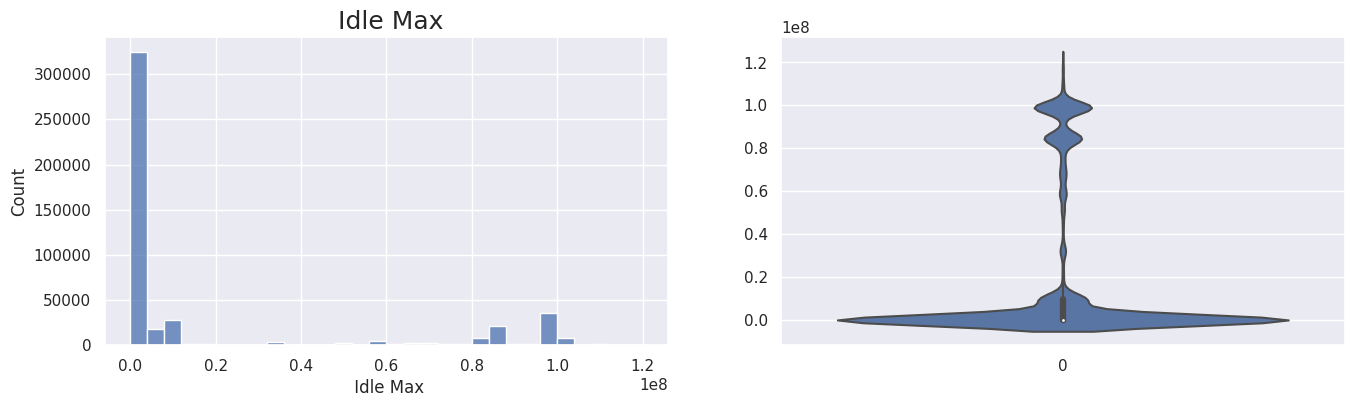

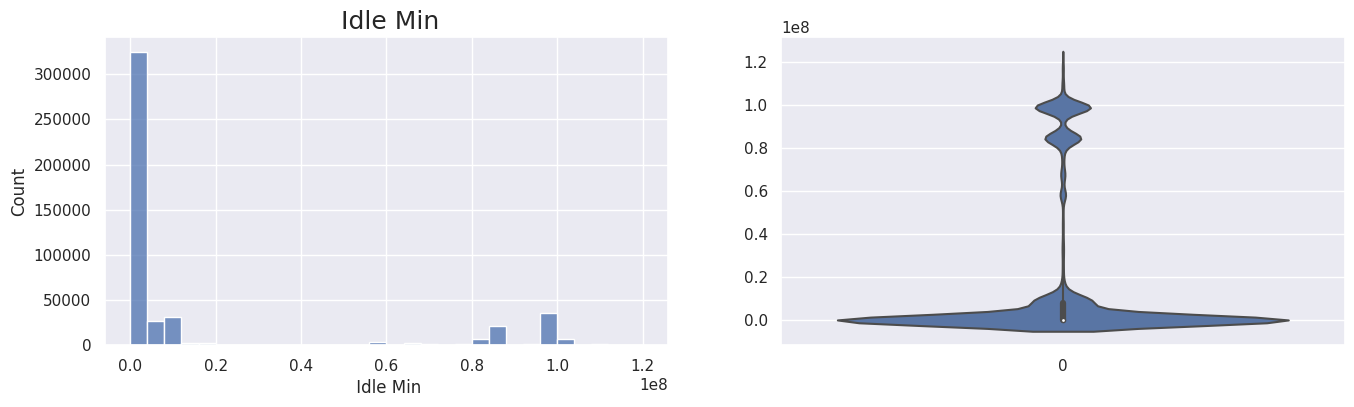

In [19]:
for column in columns_features:
     show_hists(df2[column], column, num_bins=30)

# Выделение признаков.

Выполним порядковое кодирование целевого признака, техникой OrdinalEncoder.

In [20]:
encoder = OrdinalEncoder()

In [21]:
df2['Label'] = encoder.fit_transform(df2[['Label']])

In [22]:
df2['Label'].value_counts()

0.0     232809
4.0      87251
2.0      64364
10.0     56397
3.0      10286
7.0       5933
6.0       5385
5.0       5228
11.0      3219
1.0       1953
12.0      1470
14.0       652
9.0         36
13.0        21
8.0         11
Name: Label, dtype: int64

In [23]:
features = df2.drop('Label', axis=1)
target = df2['Label']

# Выбор модели.

## Baseline. Дерево решений.

В качестве базовой модели возьмем Дерево решений. Будем использовать кросс-валидацию, выведем значение метрик.

In [24]:
scoring = ['accuracy','f1_weighted', 'precision_weighted', 'recall_weighted']

In [25]:
model_dtc = DecisionTreeClassifier(random_state=784)

In [26]:
%%time
scores = cross_validate(model_dtc, features, target, scoring=scoring)
scores

CPU times: user 1min 15s, sys: 712 ms, total: 1min 15s
Wall time: 1min 15s


{'fit_time': array([16.30024409, 15.41955066, 15.06127596, 14.25337291, 13.87398839]),
 'score_time': array([0.16300917, 0.16010904, 0.22367692, 0.21704316, 0.23086572]),
 'test_accuracy': array([0.98986348, 0.99387388, 0.99338968, 0.99442123, 0.99180026]),
 'test_f1_weighted': array([0.98933186, 0.99379309, 0.99317196, 0.99437606, 0.99158185]),
 'test_precision_weighted': array([0.99002932, 0.99442878, 0.99343561, 0.9944822 , 0.99228164]),
 'test_recall_weighted': array([0.98986348, 0.99387388, 0.99338968, 0.99442123, 0.99180026])}

In [27]:
sorted(scores.keys())

['fit_time',
 'score_time',
 'test_accuracy',
 'test_f1_weighted',
 'test_precision_weighted',
 'test_recall_weighted']

In [28]:
print('accuracy', round(scores['test_accuracy'].mean(), 6))
print('f1_weighted', round(scores['test_f1_weighted'].mean(), 6))
print('precision_weighted', round(scores['test_precision_weighted'].mean(), 6))
print('recall_weighted', round(scores['test_recall_weighted'].mean(), 6))

accuracy 0.99267
f1_weighted 0.992451
precision_weighted 0.992932
recall_weighted 0.99267


Решающее дерево дало довольно высокие значения метрик. Рассмотрим другие модели.

## Случайный лес.

In [29]:
model_rfc = RandomForestClassifier(random_state=784)

In [30]:
%%time
scores = cross_validate(model_rfc, features, target, scoring=scoring)
scores

CPU times: user 7min 23s, sys: 1.09 s, total: 7min 24s
Wall time: 7min 25s


{'fit_time': array([88.4905045 , 87.7675519 , 86.03389502, 88.06750321, 85.54527164]),
 'score_time': array([1.68544579, 2.0811522 , 1.68341732, 1.93481922, 1.64154267]),
 'test_accuracy': array([0.98975822, 0.99409492, 0.99376862, 0.99435807, 0.9914529 ]),
 'test_f1_weighted': array([0.98910036, 0.99397634, 0.99346291, 0.9941424 , 0.99104049]),
 'test_precision_weighted': array([0.9896653 , 0.99460359, 0.99368187, 0.99421555, 0.99173406]),
 'test_recall_weighted': array([0.98975822, 0.99409492, 0.99376862, 0.99435807, 0.9914529 ])}

In [31]:
print('accuracy', round(scores['test_accuracy'].mean(), 6))
print('f1_weighted', round(scores['test_f1_weighted'].mean(), 6))
print('precision_weighted', round(scores['test_precision_weighted'].mean(), 6))
print('recall_weighted', round(scores['test_recall_weighted'].mean(), 6))

accuracy 0.992687
f1_weighted 0.992345
precision_weighted 0.99278
recall_weighted 0.992687


Случайны лес не дал прироста в значениях метрик.

## CatBoostClassifier.

In [32]:
model_cb = CatBoostClassifier(random_state=784, task_type = 'GPU', verbose=0)

In [33]:
%%time
scores = cross_validate(model_cb, features, target, scoring=scoring)
scores

CPU times: user 3min 9s, sys: 1min 24s, total: 4min 33s
Wall time: 3min


{'fit_time': array([35.40828109, 33.05208945, 35.72494149, 34.17010093, 34.365242  ]),
 'score_time': array([1.32054925, 1.30439901, 1.30852818, 2.1193831 , 1.25352788]),
 'test_accuracy': array([0.99314758, 0.99483174, 0.99452649, 0.9968001 , 0.9916529 ]),
 'test_f1_weighted': array([0.99292404, 0.99465166, 0.9942762 , 0.99665625, 0.99139842]),
 'test_precision_weighted': array([0.99355868, 0.9953184 , 0.99492571, 0.996672  , 0.99280188]),
 'test_recall_weighted': array([0.99314758, 0.99483174, 0.99452649, 0.9968001 , 0.9916529 ])}

In [34]:
print('accuracy', round(scores['test_accuracy'].mean(), 6))
print('f1_weighted', round(scores['test_f1_weighted'].mean(), 6))
print('precision_weighted', round(scores['test_precision_weighted'].mean(), 6))
print('recall_weighted', round(scores['test_recall_weighted'].mean(), 6))

accuracy 0.994192
f1_weighted 0.993981
precision_weighted 0.994655
recall_weighted 0.994192


CatBoost показал более высокое значение метрик, чем Решающее дерево и Случайный лес.

## LGBMClassifier.

In [35]:
lgbm = lightgbm.LGBMClassifier(random_state=784)

In [36]:
scores = cross_validate(lgbm, features, target, scoring=scoring)
scores

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14424
[LightGBM] [Info] Number of data points in the train set: 380012, number of used features: 68
[LightGBM] [Info] Start training from score -0.713129
[LightGBM] [Info] Start training from score -5.493596
[LightGBM] [Info] Start training from score -1.998796
[LightGBM] [Info] Start training from score -3.832538
[LightGBM] [Info] Start training from score -1.694554
[LightGBM] [Info] Start training from score -4.509413
[LightGBM] [Info] Start training from score -4.479729
[LightGBM] [Info] Start training from score -4.382901
[LightGBM] [Info] Start training from score -10.650734
[LightGBM] [Info] Start training from score -9.480662
[LightGBM] [Info] Sta

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14516
[LightGBM] [Info] Number of data points in the train set: 380012, number of used features: 68
[LightGBM] [Info] Start training from score -0.713129
[LightGBM] [Info] Start training from score -5.494236
[LightGBM] [Info] Start training from score -1.998776
[LightGBM] [Info] Start training from score -3.832538
[LightGBM] [Info] Start training from score -1.694569
[LightGBM] [Info] Start training from score -4.509413
[LightGBM] [Info] Start training from score -4.479729
[LightGBM] [Info] Start training from score -4.382690
[LightGBM] [Info] Start training from score -10.650734
[LightGBM] [Info] Start training from score -9.480662
[LightGBM] [Info] Sta

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14528
[LightGBM] [Info] Number of data points in the train set: 380012, number of used features: 68
[LightGBM] [Info] Start training from score -0.713129
[LightGBM] [Info] Start training from score -5.494236
[LightGBM] [Info] Start training from score -1.998796
[LightGBM] [Info] Start training from score -3.832538
[LightGBM] [Info] Start training from score -1.694554
[LightGBM] [Info] Start training from score -4.509413
[LightGBM] [Info] Start training from score -4.479729
[LightGBM] [Info] Start training from score -4.382690
[LightGBM] [Info] Start training from score -10.650734
[LightGBM] [Info] Start training from score -9.480662
[LightGBM] [Info] Sta

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14537
[LightGBM] [Info] Number of data points in the train set: 380012, number of used features: 70
[LightGBM] [Info] Start training from score -0.713129
[LightGBM] [Info] Start training from score -5.494236
[LightGBM] [Info] Start training from score -1.998796
[LightGBM] [Info] Start training from score -3.832660
[LightGBM] [Info] Start training from score -1.694554
[LightGBM] [Info] Start training from score -4.509174
[LightGBM] [Info] Start training from score -4.479729
[LightGBM] [Info] Start training from score -4.382901
[LightGBM] [Info] Start training from score -10.650734
[LightGBM] [Info] Start training from score -9.480662
[LightGBM] [Info] Sta

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14529
[LightGBM] [Info] Number of data points in the train set: 380012, number of used features: 70
[LightGBM] [Info] Start training from score -0.713124
[LightGBM] [Info] Start training from score -5.493596
[LightGBM] [Info] Start training from score -1.998796
[LightGBM] [Info] Start training from score -3.832538
[LightGBM] [Info] Start training from score -1.694554
[LightGBM] [Info] Start training from score -4.509174
[LightGBM] [Info] Start training from score -4.479729
[LightGBM] [Info] Start training from score -4.382901
[LightGBM] [Info] Start training from score -10.768517
[LightGBM] [Info] Start training from score -9.515754
[LightGBM] [Info] Sta

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'fit_time': array([82.40049863, 86.1671145 , 83.43140459, 86.70804501, 84.30908227]),
 'score_time': array([6.39138198, 8.39933944, 7.4874866 , 7.2417388 , 6.35630631]),
 'test_accuracy': array([0.65710557, 0.80050104, 0.56042441, 0.73470311, 0.42798648]),
 'test_f1_weighted': array([0.64271926, 0.77012827, 0.58557097, 0.72458552, 0.44859922]),
 'test_precision_weighted': array([0.65837509, 0.82500544, 0.68632849, 0.7172261 , 0.73463685]),
 'test_recall_weighted': array([0.65710557, 0.80050104, 0.56042441, 0.73470311, 0.42798648])}

In [37]:
print('accuracy', round(scores['test_accuracy'].mean(), 6))
print('f1_weighted', round(scores['test_f1_weighted'].mean(), 6))
print('precision_weighted', round(scores['test_precision_weighted'].mean(), 6))
print('recall_weighted', round(scores['test_recall_weighted'].mean(), 6))

accuracy 0.636144
f1_weighted 0.634321
precision_weighted 0.724314
recall_weighted 0.636144


LGBM показал самые низкие значения метрик, возможно причина в недостаточной подготовке данных для корректной работы модели. Для дальнейшей работы выберем CatBoost, который показал самые высокие значения метрик.


# Подготовка данных

## Разделение выборки

Разделим данные на обучающую - 80% и тестовую - 20 % выборки.

In [38]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=123, stratify = target)    # выделим тестовую выборку


print('Размер обучающей выборки признаков:            ', features_train.shape)
print('Размер обучающей выборки целевого признака:    ', target_train.shape)
print('Размер тестовой выборки признаков:             ', features_test.shape)
print('Размер тестовой выборки целевого признака:     ', target_test.shape)

Размер обучающей выборки признаков:             (380012, 78)
Размер обучающей выборки целевого признака:     (380012,)
Размер тестовой выборки признаков:              (95003, 78)
Размер тестовой выборки целевого признака:      (95003,)


## Выделение категориальных и количественных признаков.

In [39]:
cat_columns = [' Down/Up Ratio', 'Fwd PSH Flags', ' Fwd URG Flags', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count', ' CWE Flag Count', ' ECE Flag Count']


In [40]:
len(cat_columns)

11

In [41]:
cat_columns

[' Down/Up Ratio',
 'Fwd PSH Flags',
 ' Fwd URG Flags',
 'FIN Flag Count',
 ' SYN Flag Count',
 ' RST Flag Count',
 ' PSH Flag Count',
 ' ACK Flag Count',
 ' URG Flag Count',
 ' CWE Flag Count',
 ' ECE Flag Count']

In [42]:
num_columns = [col for col in list(df2.columns) if col not in cat_columns and col != 'Label']

In [43]:
len(num_columns)

67

## OHE

In [44]:
ohe_enc = OneHotEncoder(drop = 'first', handle_unknown ='ignore')
ohe_enc.fit(features_train[cat_columns])
new_columns = ohe_enc.get_feature_names_out(cat_columns)

In [45]:
features_train_ohe = pd.DataFrame(ohe_enc.transform(features_train[cat_columns]).toarray(), columns = new_columns)
features_test_ohe = pd.DataFrame(ohe_enc.transform(features_test[cat_columns]).toarray(), columns = new_columns)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [46]:
features_train_reset_index = features_train.reset_index()
features_test_reset_index = features_test.reset_index()

In [47]:
features_train_merged = pd.concat([features_train_reset_index['index'], features_train_reset_index[num_columns], features_train_ohe], axis=1)
features_test_merged = pd.concat([features_test_reset_index['index'], features_test_reset_index[num_columns], features_test_ohe], axis=1)

In [48]:
features_train_merged = features_train_merged.set_index('index')
features_test_merged = features_test_merged.set_index('index')

In [49]:
features_train_merged.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd PSH Flags_1,Fwd URG Flags_1,FIN Flag Count_1,SYN Flag Count_1,RST Flag Count_1,PSH Flag Count_1,ACK Flag Count_1,URG Flag Count_1,CWE Flag Count_1,ECE Flag Count_1
index,,,,,,,,,,,,,,,,,,,,,
123393,443,60919112,16,14,1159,5486,760,0,72.44,191.5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
319368,80,707042,4,0,24,0,6,6,6.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
33225,443,9989820,7,10,3217,4843,2677,0,459.50,987.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
165040,443,395065,3,1,0,0,0,0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
255686,80,85460823,5,6,822,11595,408,0,164.40,222.4,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Масштабирование

In [50]:
features_train_s = features_train_merged
features_test_s = features_test_merged

In [51]:
scaler = RobustScaler()
scaler.fit(features_train_s[num_columns])

features_train_s[num_columns] = scaler.transform(features_train_s[num_columns])
features_test_s[num_columns] = scaler.transform(features_test_s[num_columns])

In [52]:
features_train_s.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd PSH Flags_1,Fwd URG Flags_1,FIN Flag Count_1,SYN Flag Count_1,RST Flag Count_1,PSH Flag Count_1,ACK Flag Count_1,URG Flag Count_1,CWE Flag Count_1,ECE Flag Count_1
index,,,,,,,,,,,,,,,,,,,,,
123393,1.0,2.022763,3.25,2.4,3.282738,0.459056,2.341935,0.0,0.907578,1.684257,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
319368,0.0,0.019380,0.25,-0.4,-0.095238,-0.014324,-0.090323,1.0,-0.547525,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
33225,1.0,0.328238,1.00,1.6,9.407738,0.403572,8.525806,0.0,9.384582,8.680739,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
165040,1.0,0.009000,0.00,-0.2,-0.166667,-0.014324,-0.109677,0.0,-0.678931,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
255686,0.0,2.839317,0.50,0.8,2.279762,0.986194,1.206452,0.0,2.921594,1.956025,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Обучение модели CatBoost на тренировочной выборке.

In [53]:
param_grid = {'iterations': [1000]}

model_cb = CatBoostClassifier(random_state=784, task_type = 'GPU', verbose=0)
search_cb = GridSearchCV(
                      estimator = model_cb,
                      param_grid = param_grid,
                      cv=5
                      )

In [54]:
%%time
search_cb.fit(features_train_s, target_train)

CPU times: user 3min 25s, sys: 1min 33s, total: 4min 59s
Wall time: 3min 15s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7be5fe524160>,
             param_grid={'iterations': [1000]})

In [55]:
print('model params: ', search_cb.best_params_)
print(f"accuracy для модели CatBoost на кросс валидации: {search_cb.best_score_:.3f}")

model params:  {'iterations': 1000}
accuracy для модели CatBoost на кросс валидации: 0.997


In [56]:
prediction = search_cb.predict(features_test_s) # передача тестовой выборки в модель

In [57]:
print(classification_report(target_test, prediction))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     46562
         1.0       0.95      0.98      0.96       391
         2.0       1.00      1.00      1.00     12873
         3.0       1.00      1.00      1.00      2057
         4.0       1.00      1.00      1.00     17450
         5.0       0.99      1.00      0.99      1046
         6.0       1.00      1.00      1.00      1077
         7.0       1.00      1.00      1.00      1187
         8.0       1.00      1.00      1.00         2
         9.0       1.00      0.86      0.92         7
        10.0       1.00      1.00      1.00     11279
        11.0       1.00      1.00      1.00       644
        12.0       0.74      0.86      0.79       294
        13.0       1.00      0.75      0.86         4
        14.0       0.48      0.30      0.37       130

    accuracy                           1.00     95003
   macro avg       0.94      0.91      0.93     95003
weighted avg       1.00   

1. 'BENIGN',
2. 'Bot',
3. 'DDoS',
4. 'DoS GoldenEye',
5. 'DoS Hulk',
6. 'DoS Slowhttptest',
7. 'DoS slowloris',
8. 'FTP-Patator',
9. 'Heartbleed',
10. 'Infiltration',
11. 'PortScan',
12. 'SSH-Patator',
13. 'Web Attack � Brute Force',
14. 'Web Attack � Sql Injection',
15. 'Web Attack � XSS'  

# Вывод:
В целом качество предсказания финальной модели хорошее, но заметно снижение показателей метрик на малочисленных классах. Были проведены эксперименты с подбором различных гиперпараметров при помощи GridSearchCV, а именно:

* 'depth': [3, 4, 5, 7]
* 'iterations': [50, 100, 500, 700, 1000]
* 'learning_rate': [0.05, 0.1, 0.3, 0.5]
* 'l2_leaf_reg': [1, 2, 3, 5, 7]
* cv = 2; 3; 5.

Но к увеличению значений метрик на тестовой выборке это не привело, а время обучения кратно увеличилось, поэтому в финальной версии модели была применена только кросс-валидация со значением cv=5 и 1000 итераций в гиперпараметрах GridSearchCV.

